In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import torch
import hdbscan

from utils import parse_result_line, drop_correlated_features, drop_skewed_features, aggregate_columns, plot_cluster_averages, plot_solution_correlations
from aencoder import Autoencoder, train_autoencoder

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/d

In [2]:
# Read all files and parse aencoder results
results_dir = "/Users/leo/Programming/PLR/Leo/main/final/grid_results"
result_files = [f for f in os.listdir(results_dir) if f.startswith('aencoder_grid') and f.endswith('.txt')]

all_results = []
for file in result_files:
    dataset_number = int(re.search(r'_([1-5])\.txt$', file).group(1))  # Extract dataset number from file name
    with open(os.path.join(results_dir, file), 'r') as f:
        for line in f:
            parsed_line = parse_result_line(line, dataset_number)
            if parsed_line:
                all_results.append(parsed_line)

# Filter and sort results
filtered_results = [res for res in all_results if 5 <= res['num_clusters'] <= 13]
top_results = sorted(filtered_results, key=lambda x: x['silhouette_score'], reverse=True)[:10]

In [3]:
result_files

['aencoder_grid_2.txt',
 'aencoder_grid_3.txt',
 'aencoder_grid_1.txt',
 'aencoder_grid_4.txt',
 'aencoder_grid_5.txt']

In [4]:
top_results

[{'silhouette_score': 0.6344,
  'num_clusters': 8,
  'skew_threshold': 0.8,
  'corr_threshold': 0.6,
  'hidden_size': 32,
  'latent_dim': 2,
  'learning_rate': 0.01,
  'epochs': 500,
  'hdbscan_params': {'min_cluster_size': 15, 'min_samples': 15},
  'dataset': 4},
 {'silhouette_score': 0.6141,
  'num_clusters': 5,
  'skew_threshold': 0.75,
  'corr_threshold': 0.6,
  'hidden_size': 32,
  'latent_dim': 2,
  'learning_rate': 0.01,
  'epochs': 500,
  'hdbscan_params': {'min_cluster_size': 20, 'min_samples': 25},
  'dataset': 4},
 {'silhouette_score': 0.6129,
  'num_clusters': 9,
  'skew_threshold': 0.75,
  'corr_threshold': 0.9,
  'hidden_size': 64,
  'latent_dim': 8,
  'learning_rate': 0.01,
  'epochs': 500,
  'hdbscan_params': {'min_cluster_size': 5, 'min_samples': 10},
  'dataset': 3},
 {'silhouette_score': 0.6073,
  'num_clusters': 5,
  'skew_threshold': 0.75,
  'corr_threshold': 0.6,
  'hidden_size': 32,
  'latent_dim': 2,
  'learning_rate': 0.01,
  'epochs': 500,
  'hdbscan_params': 

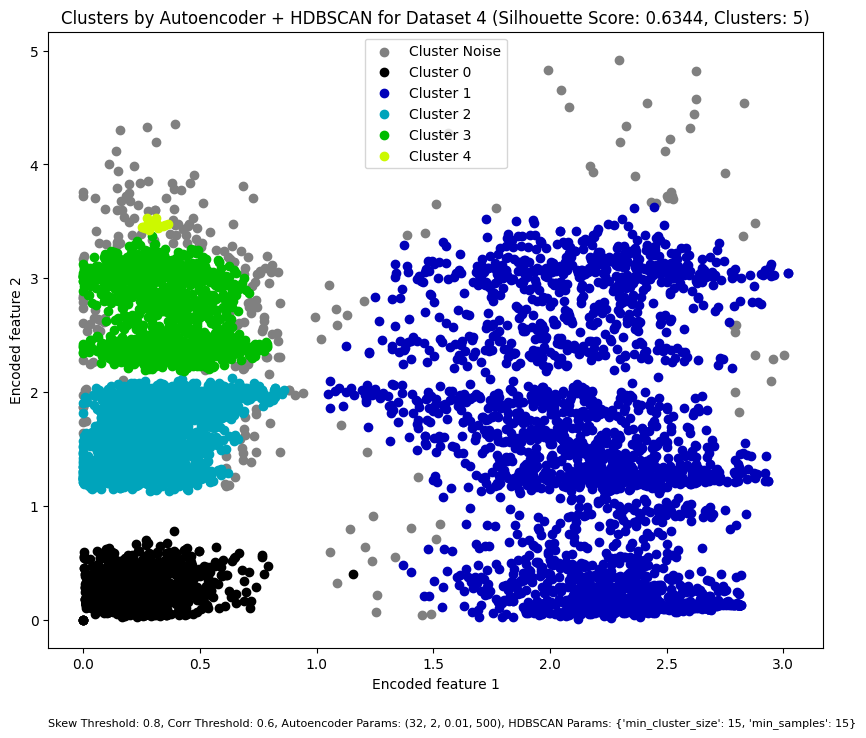

Saved cluster solution to /Users/leo/Programming/PLR/Leo/main/final/grid_autoencoder/cluster_solutions/cluster_solution_4_0.csv


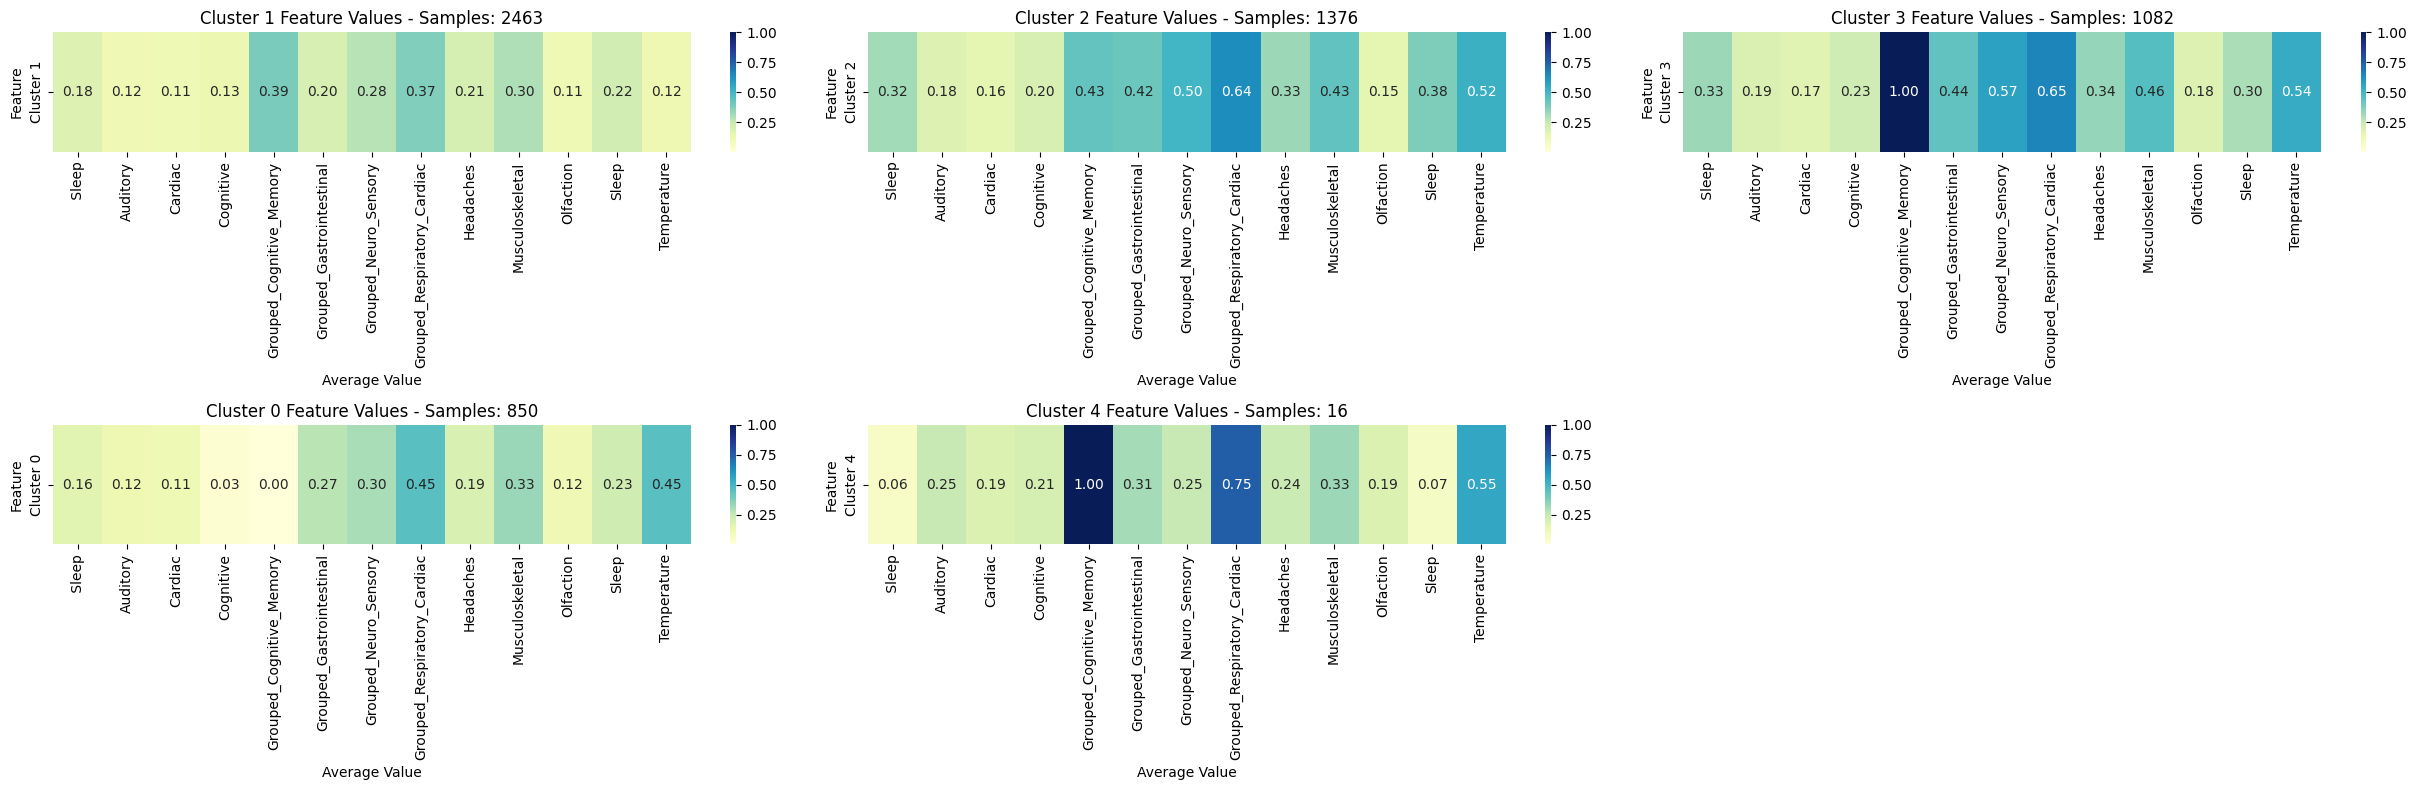

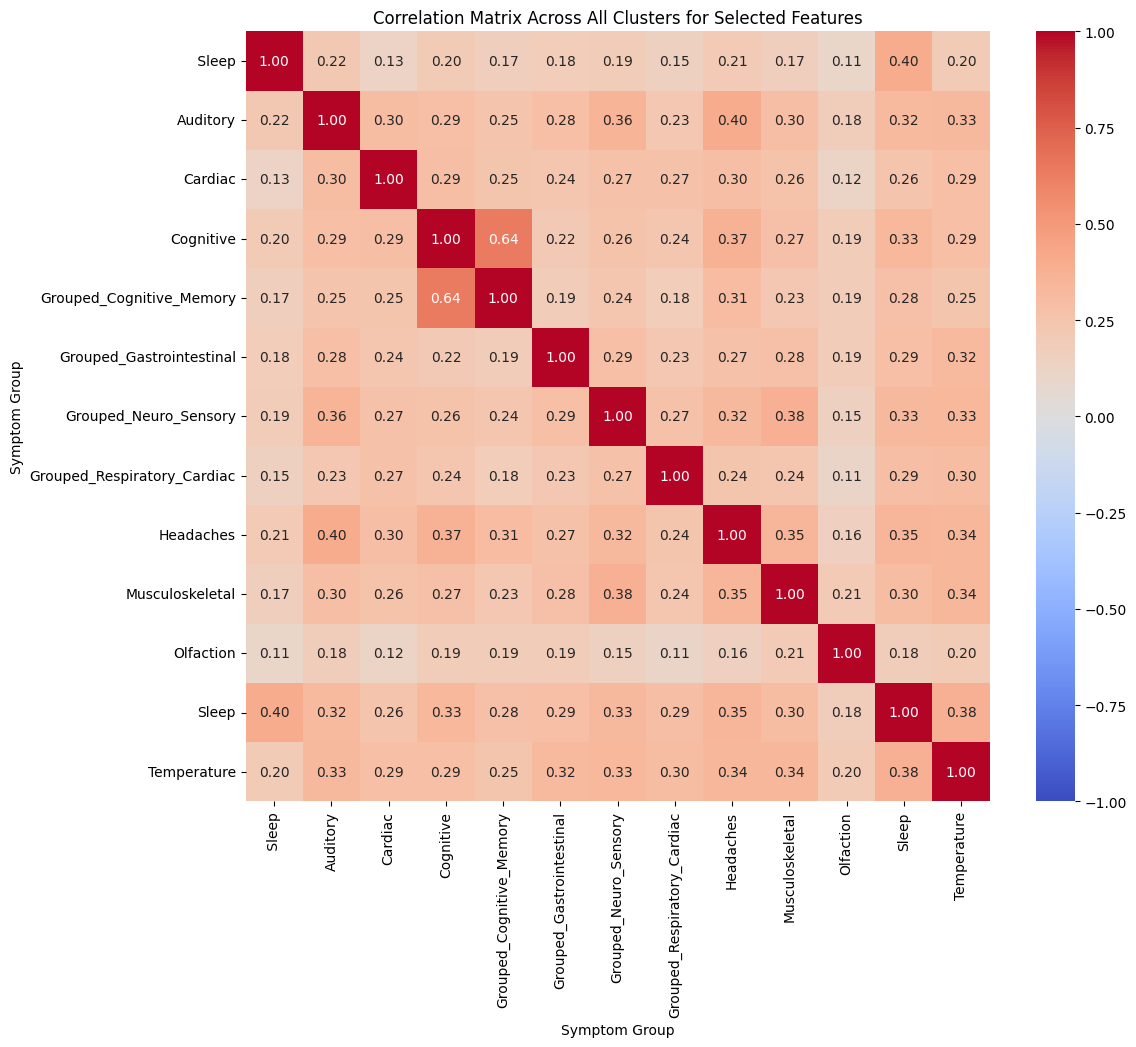

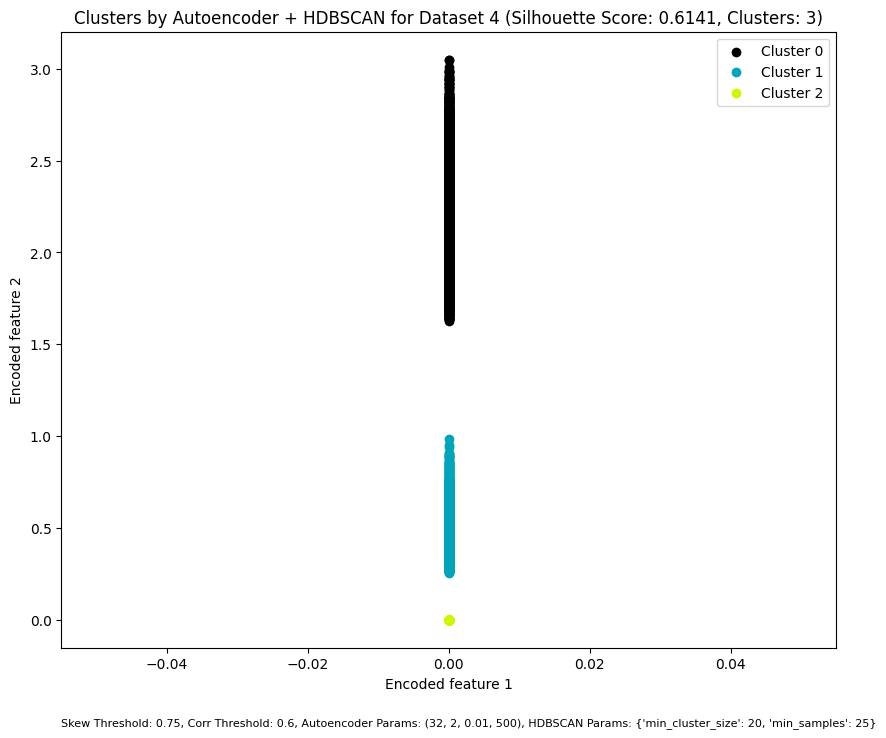

Saved cluster solution to /Users/leo/Programming/PLR/Leo/main/final/grid_autoencoder/cluster_solutions/cluster_solution_4_1.csv


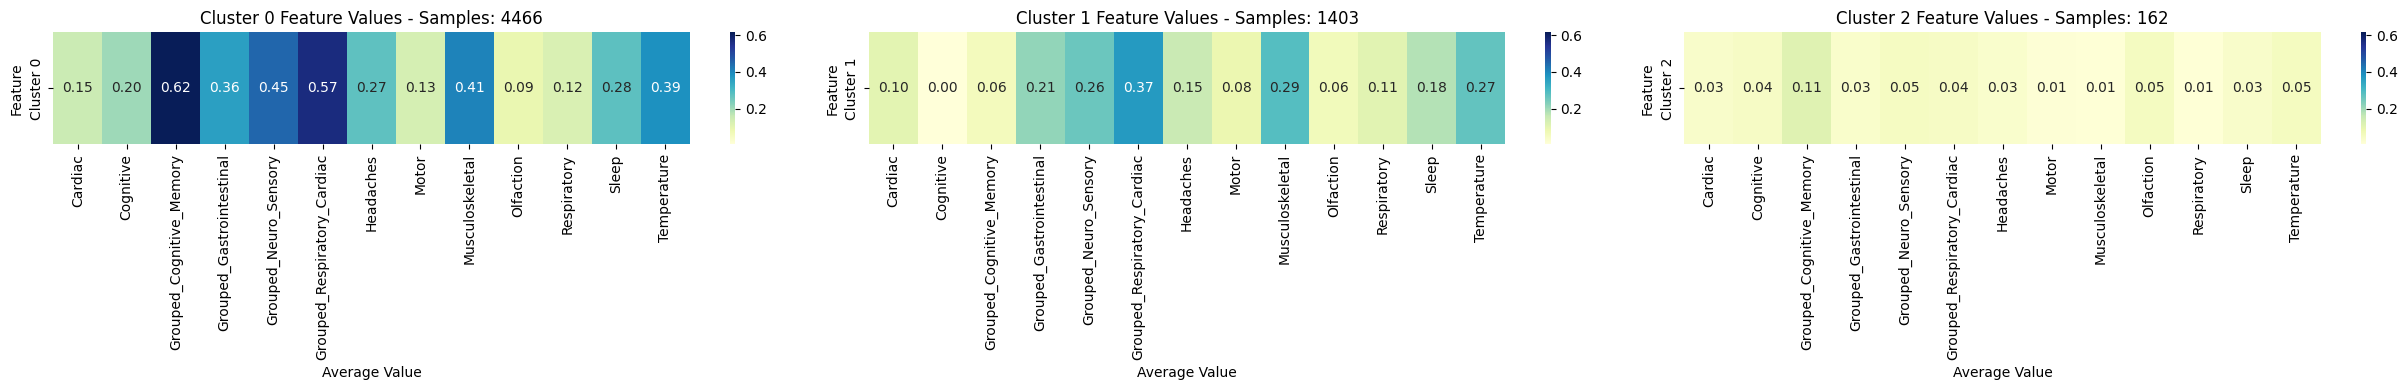

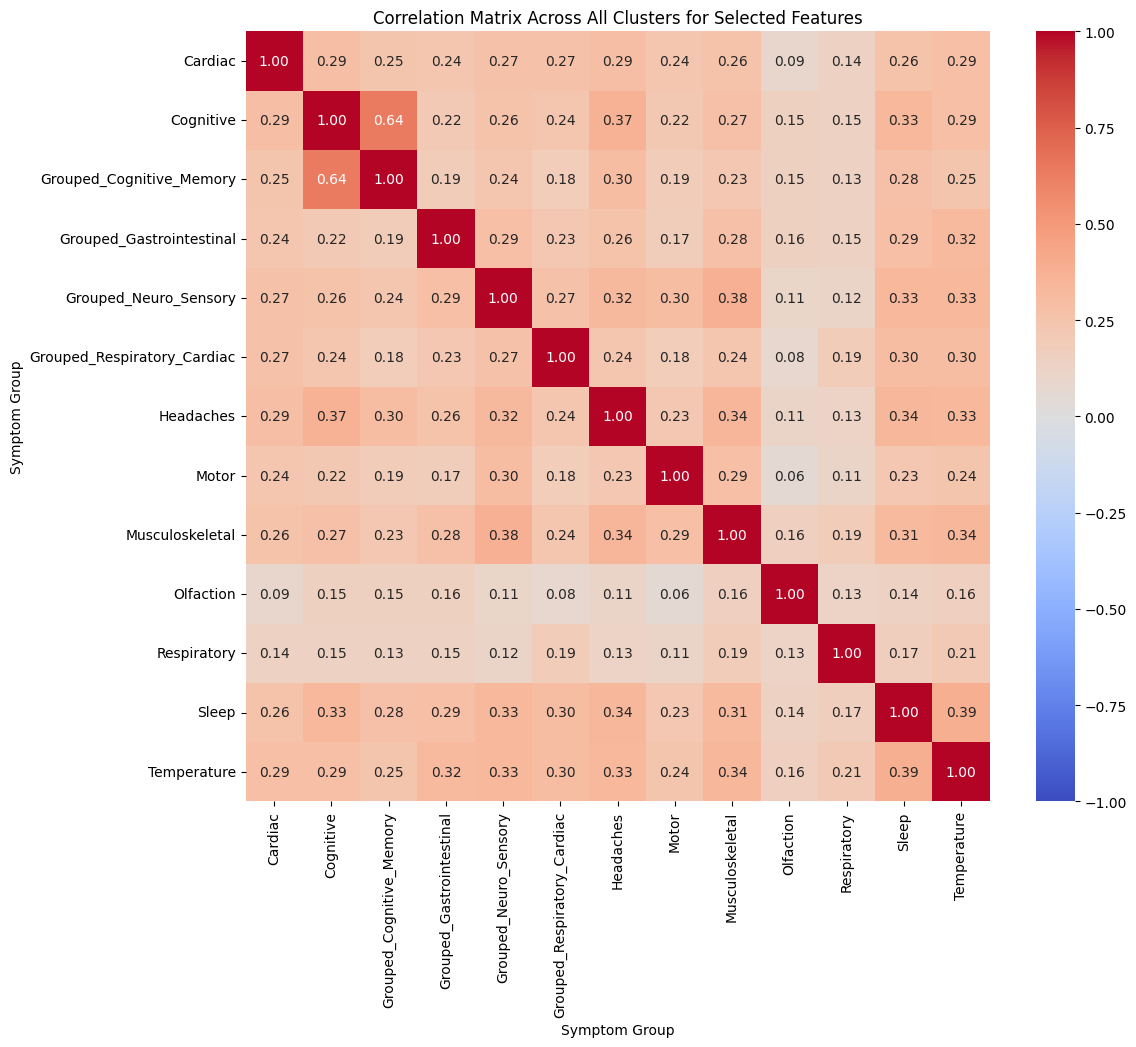

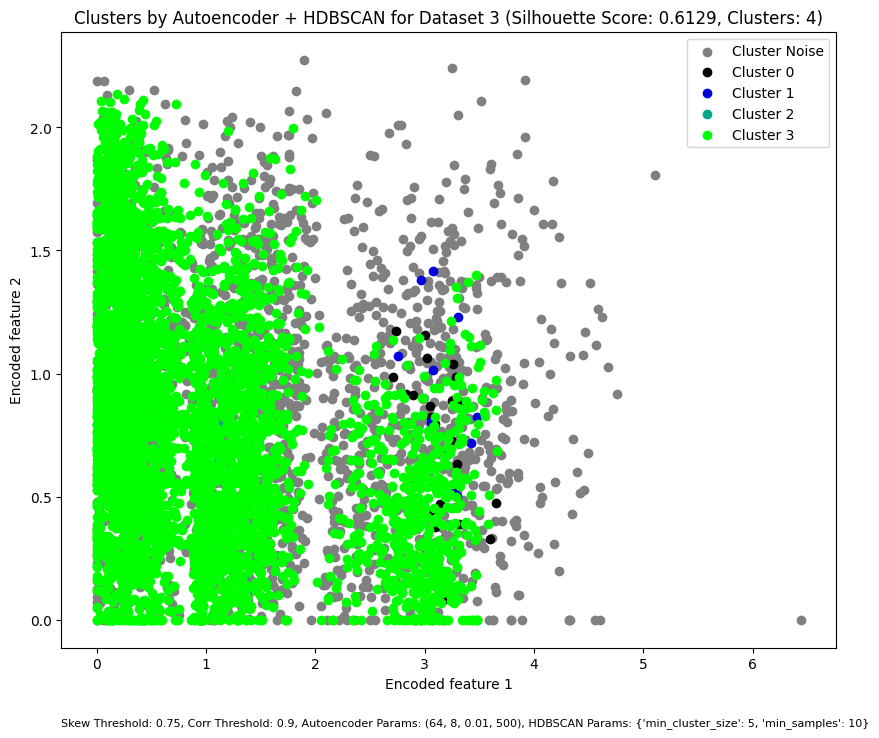

Saved cluster solution to /Users/leo/Programming/PLR/Leo/main/final/grid_autoencoder/cluster_solutions/cluster_solution_3_2.csv


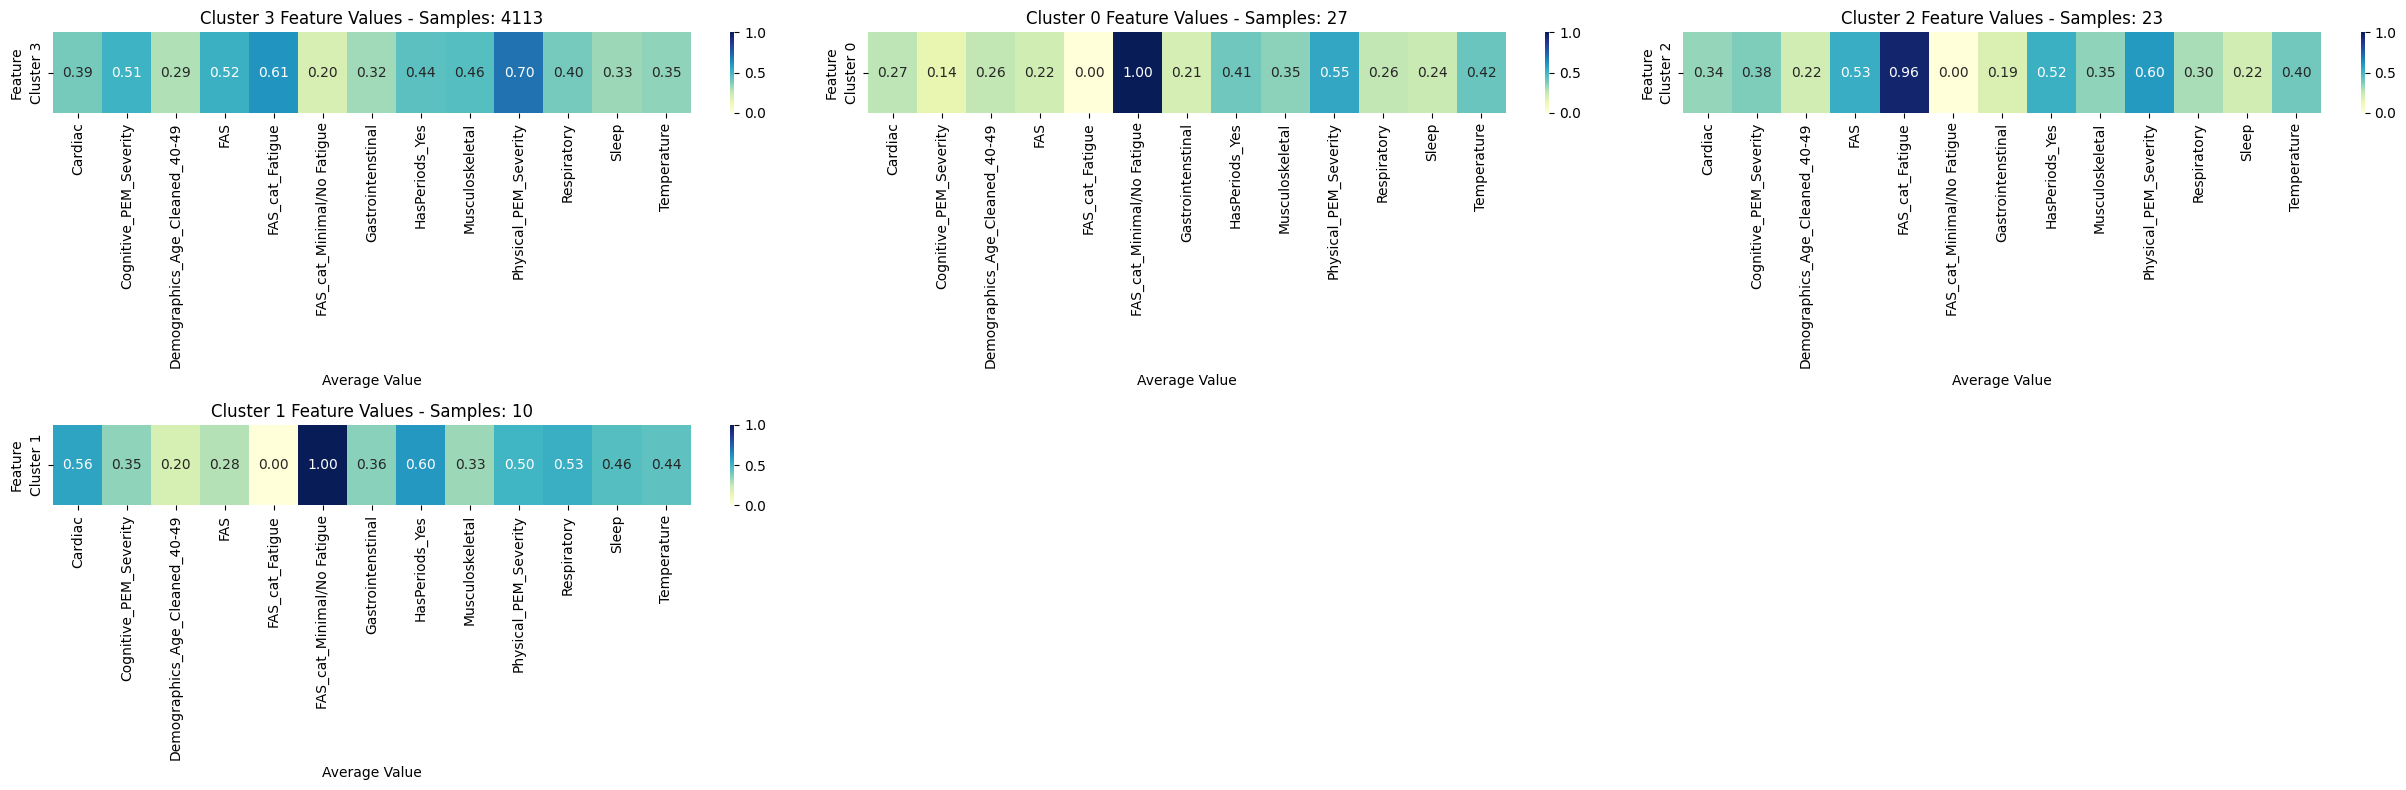

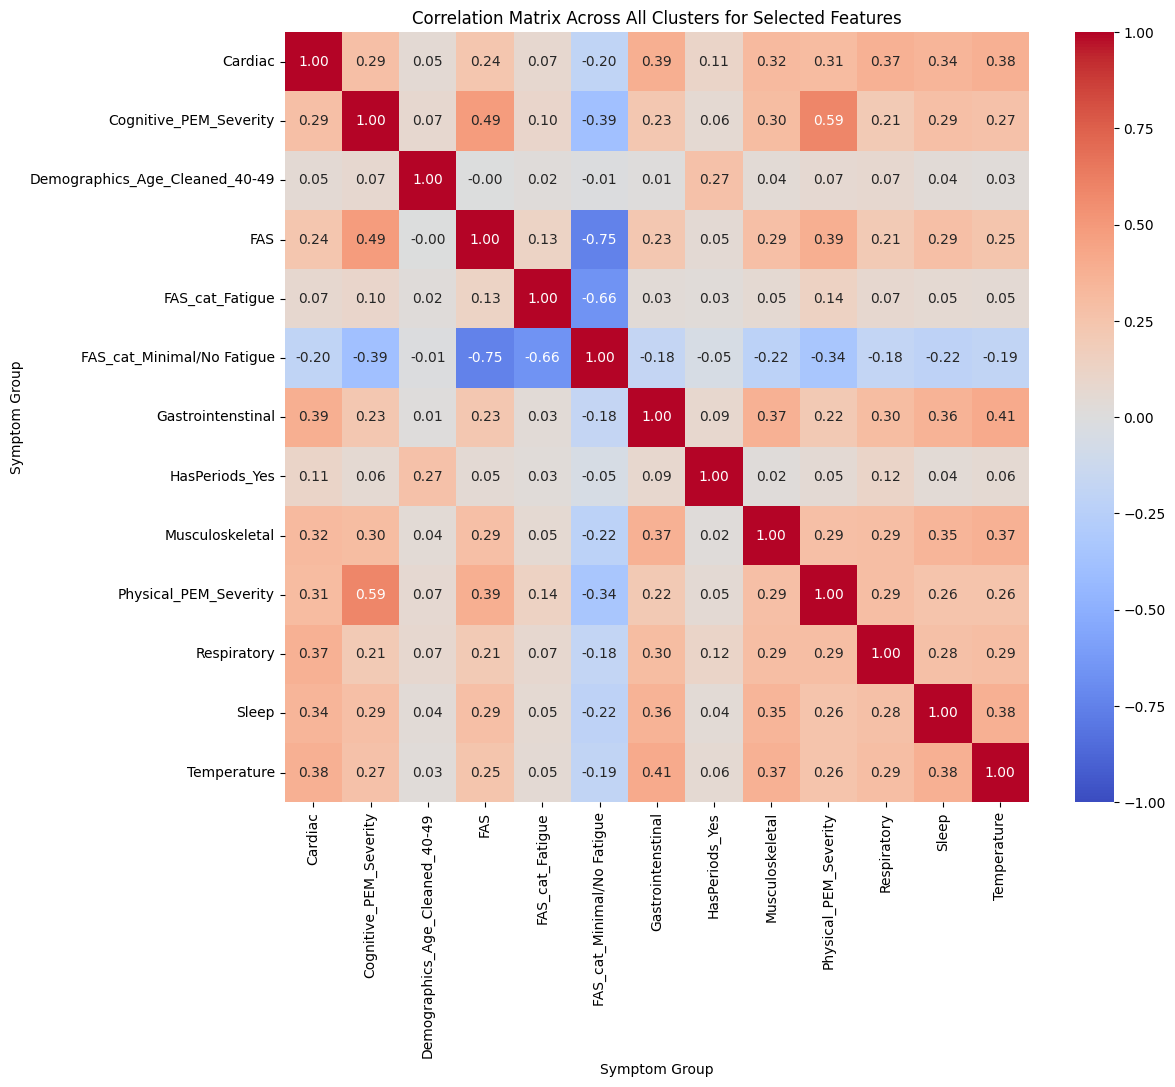

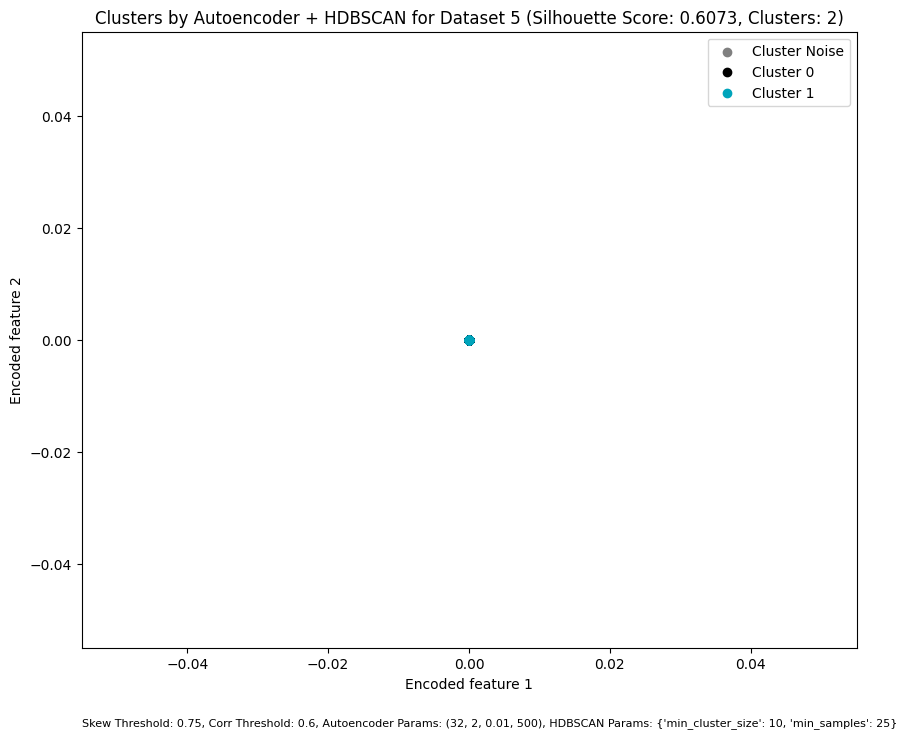

Saved cluster solution to /Users/leo/Programming/PLR/Leo/main/final/grid_autoencoder/cluster_solutions/cluster_solution_5_3.csv


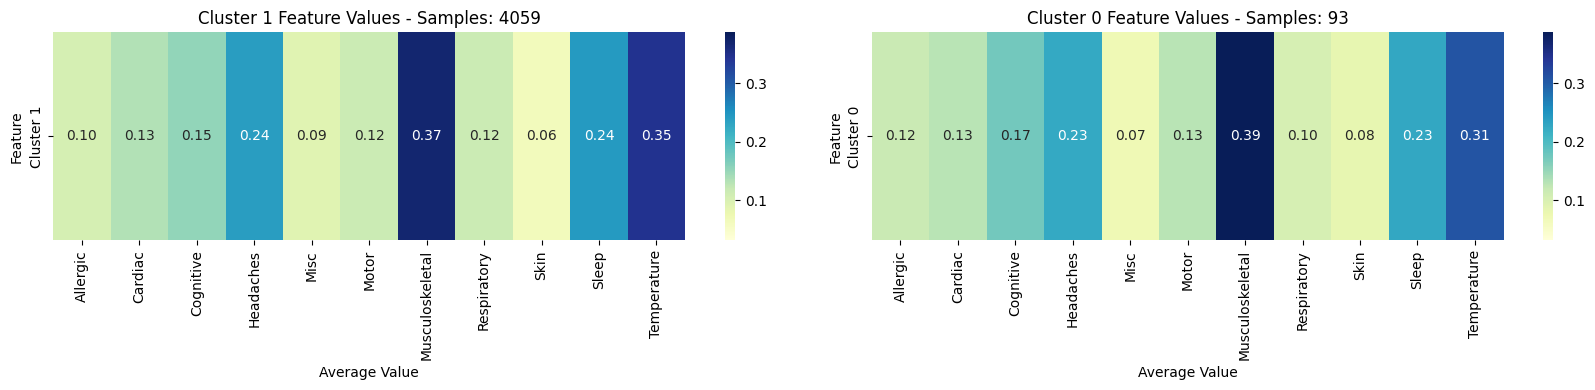

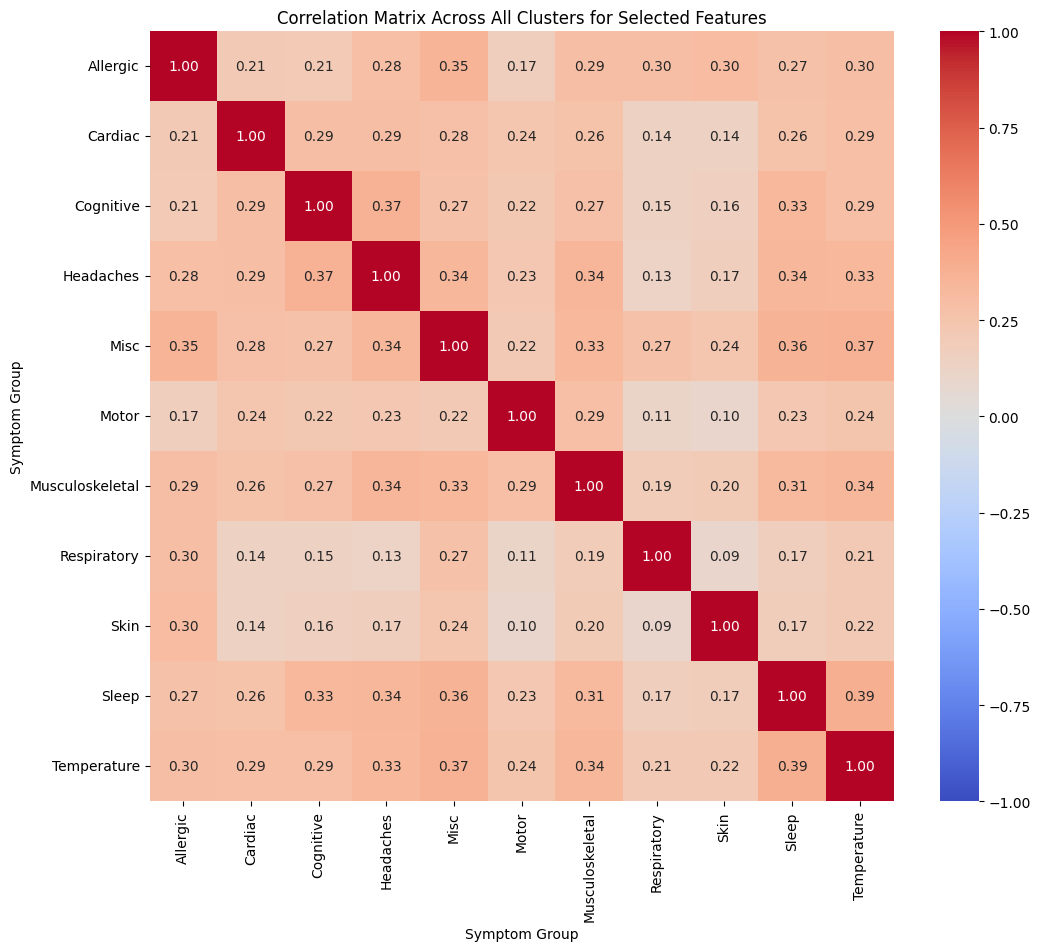

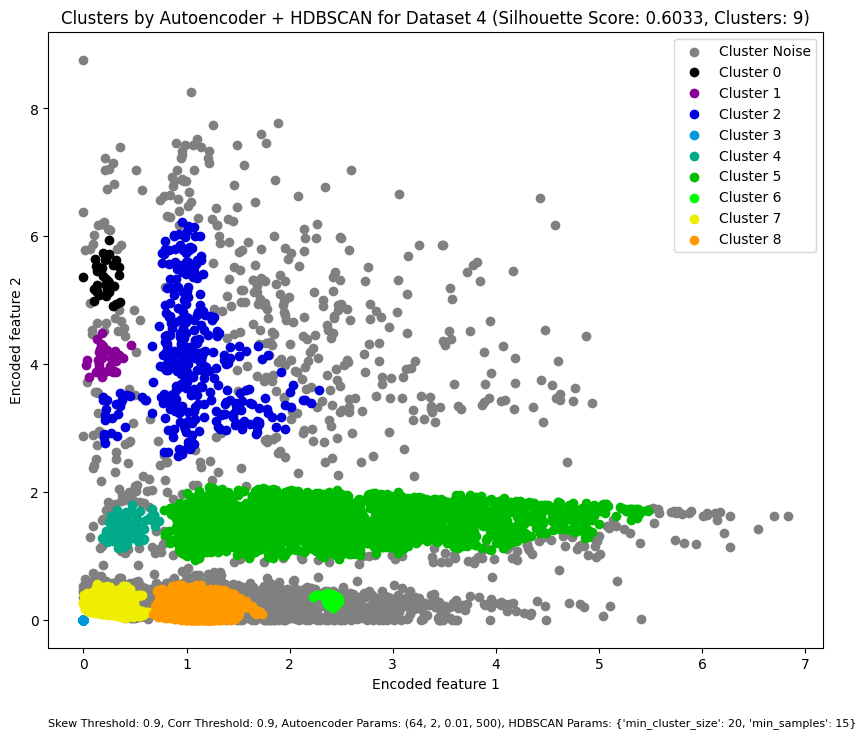

Saved cluster solution to /Users/leo/Programming/PLR/Leo/main/final/grid_autoencoder/cluster_solutions/cluster_solution_4_4.csv


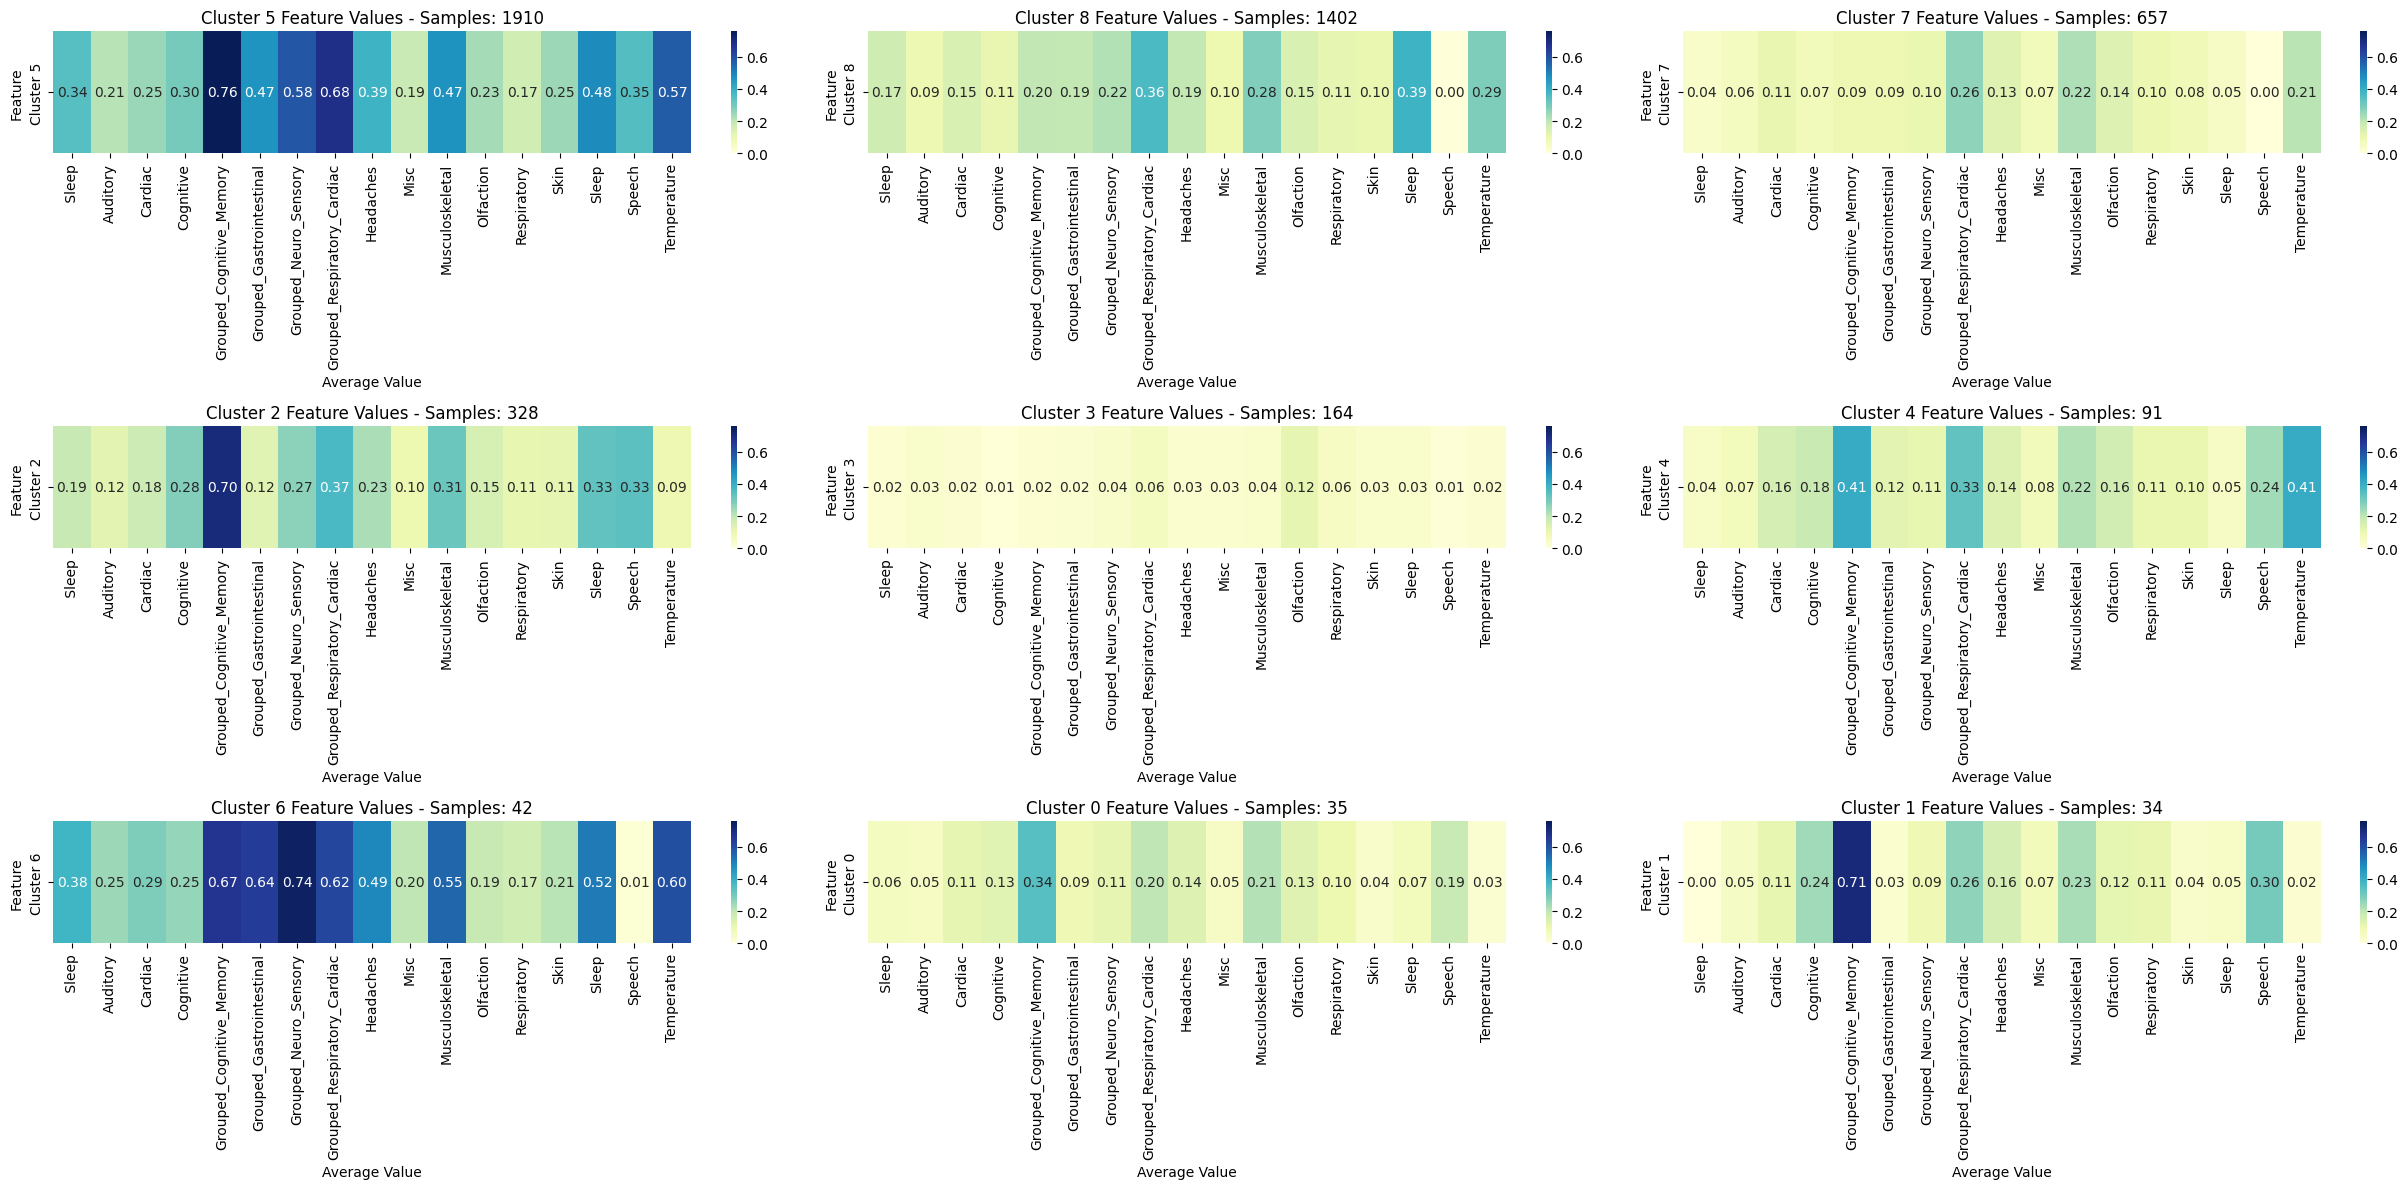

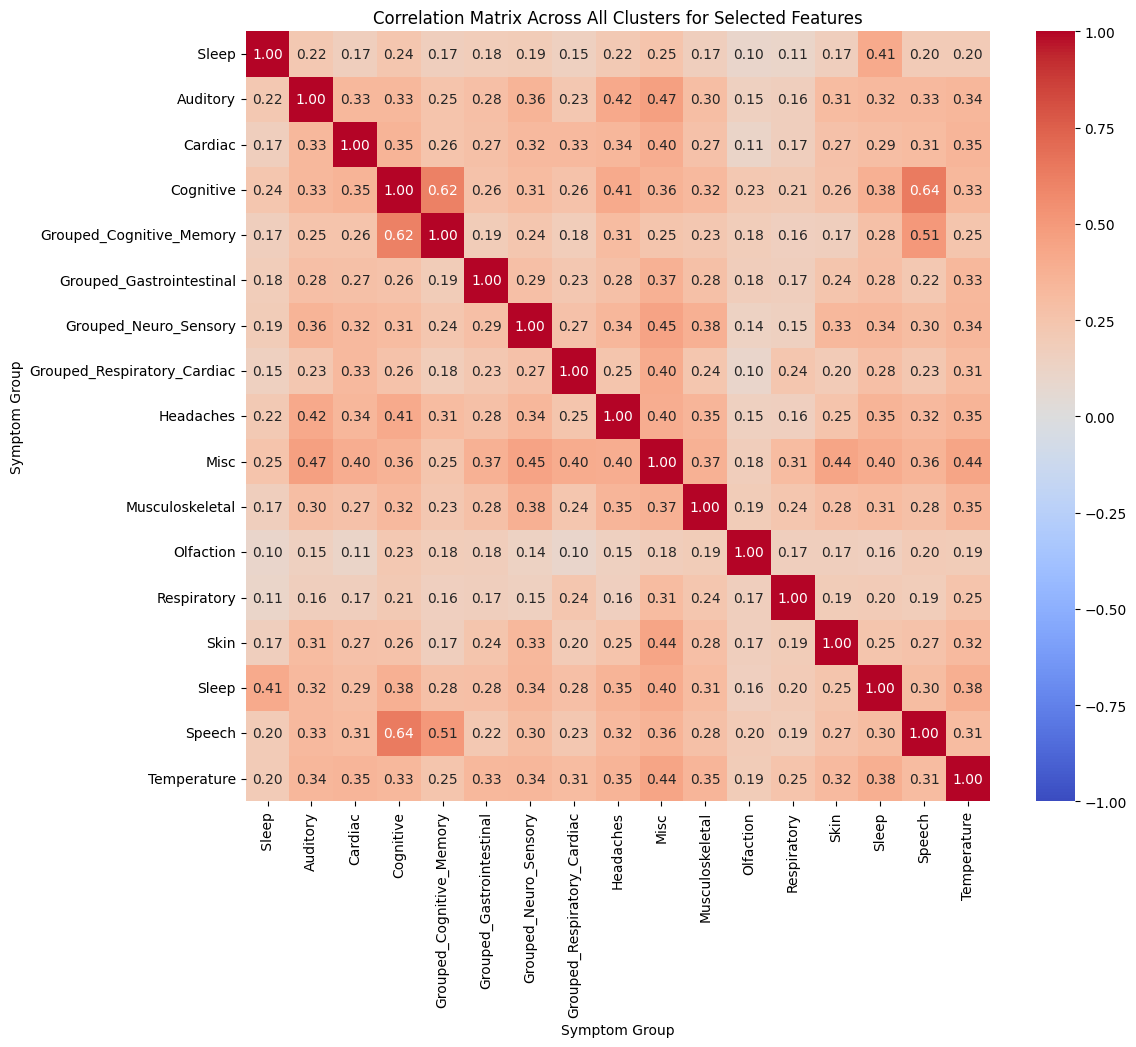

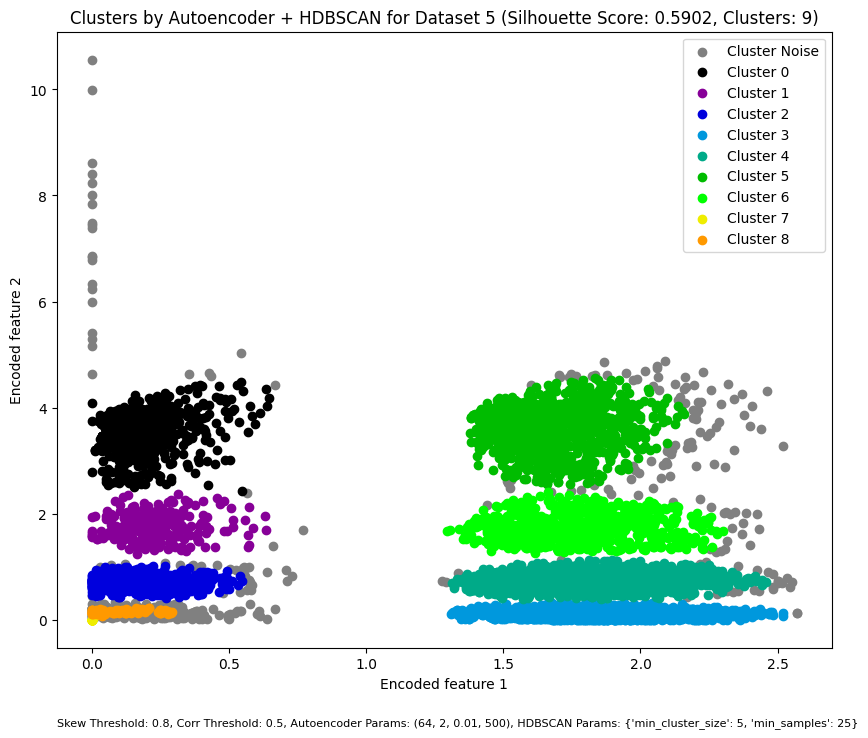

Saved cluster solution to /Users/leo/Programming/PLR/Leo/main/final/grid_autoencoder/cluster_solutions/cluster_solution_5_5.csv


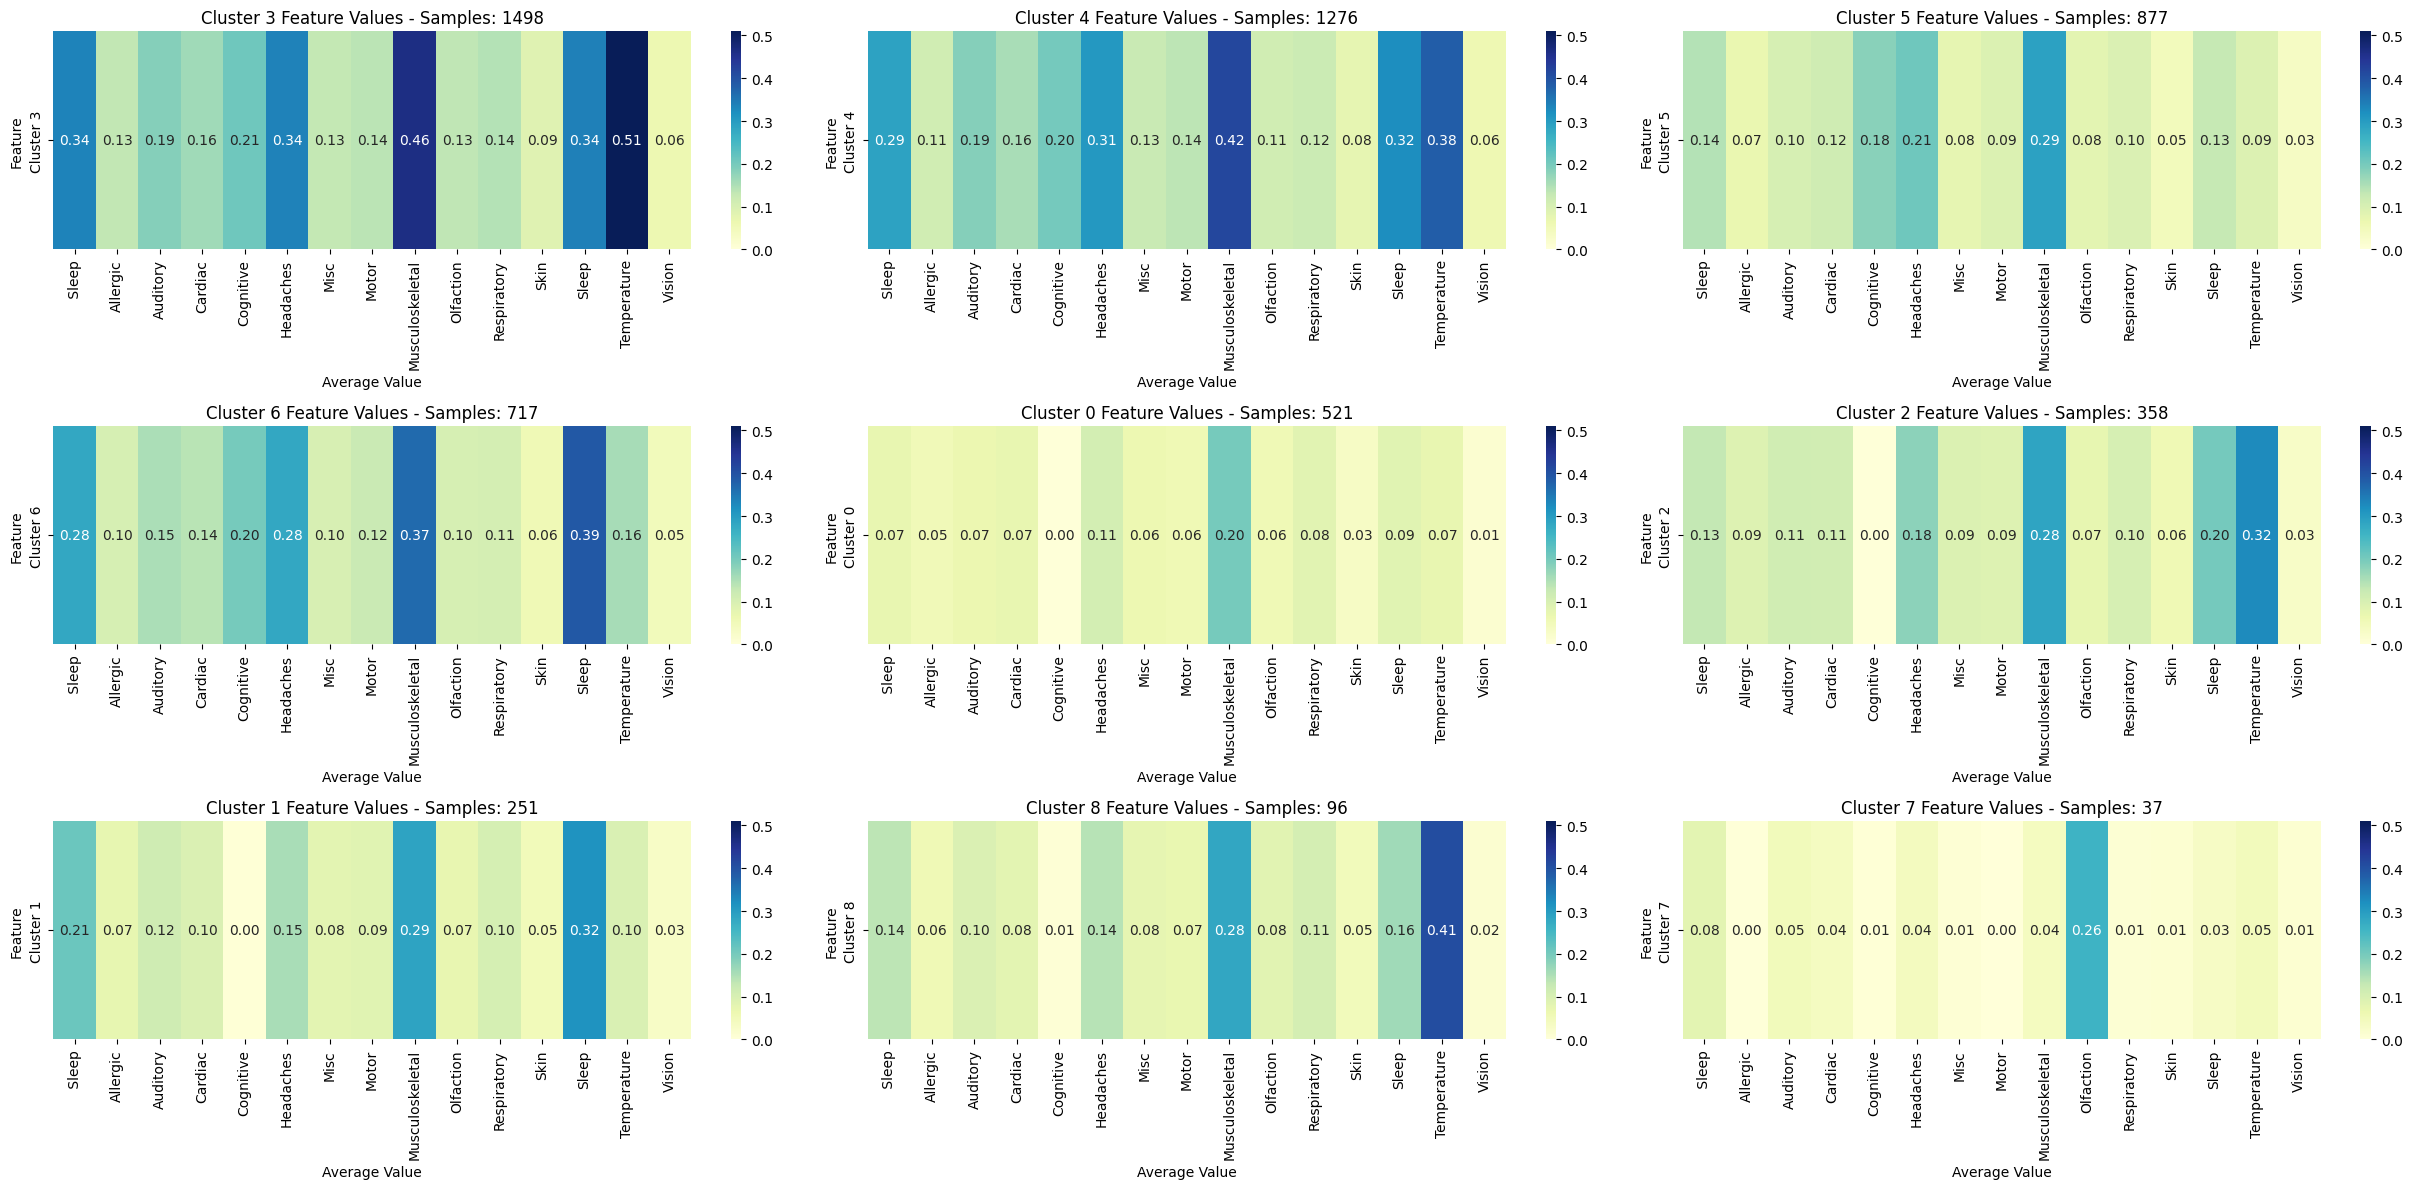

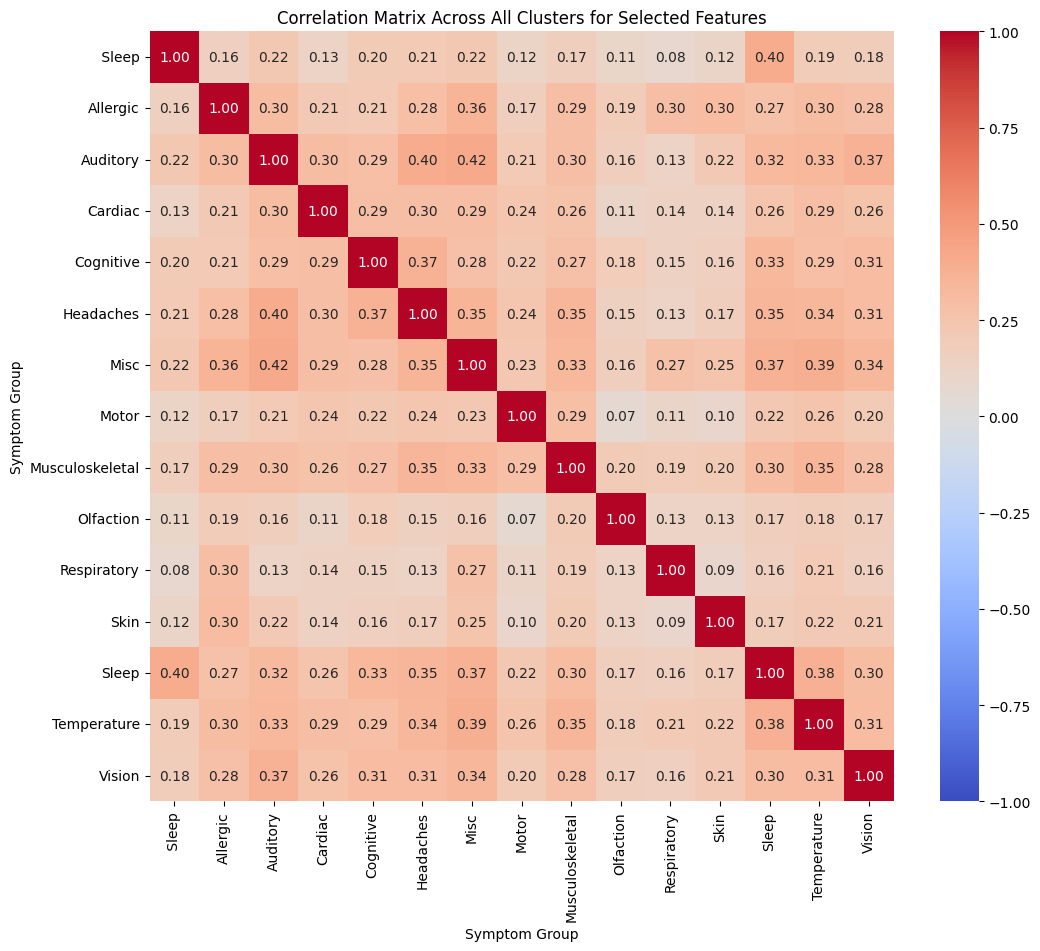

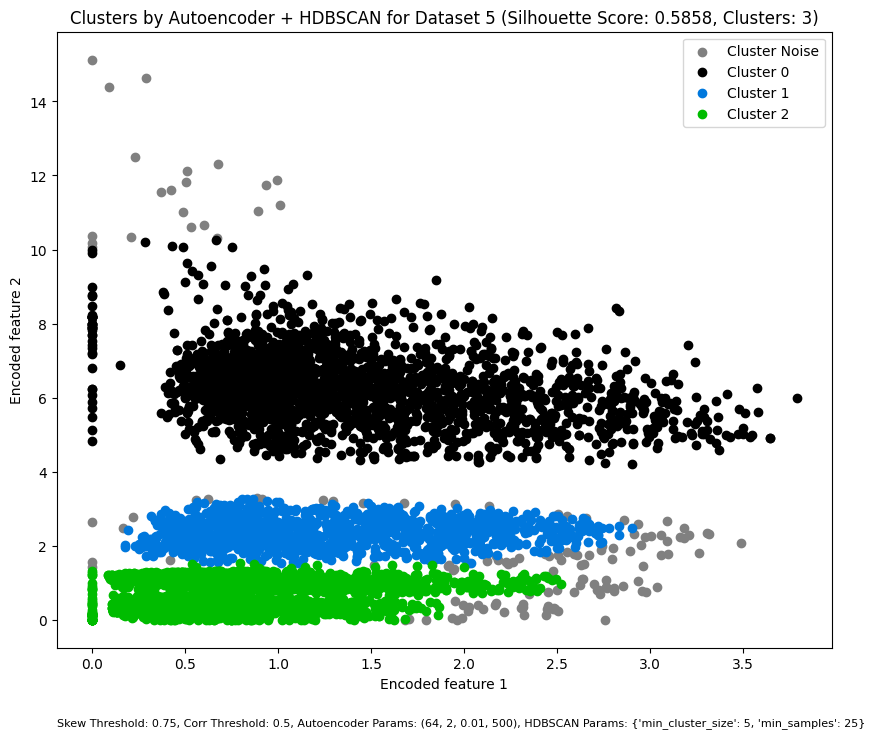

Saved cluster solution to /Users/leo/Programming/PLR/Leo/main/final/grid_autoencoder/cluster_solutions/cluster_solution_5_6.csv


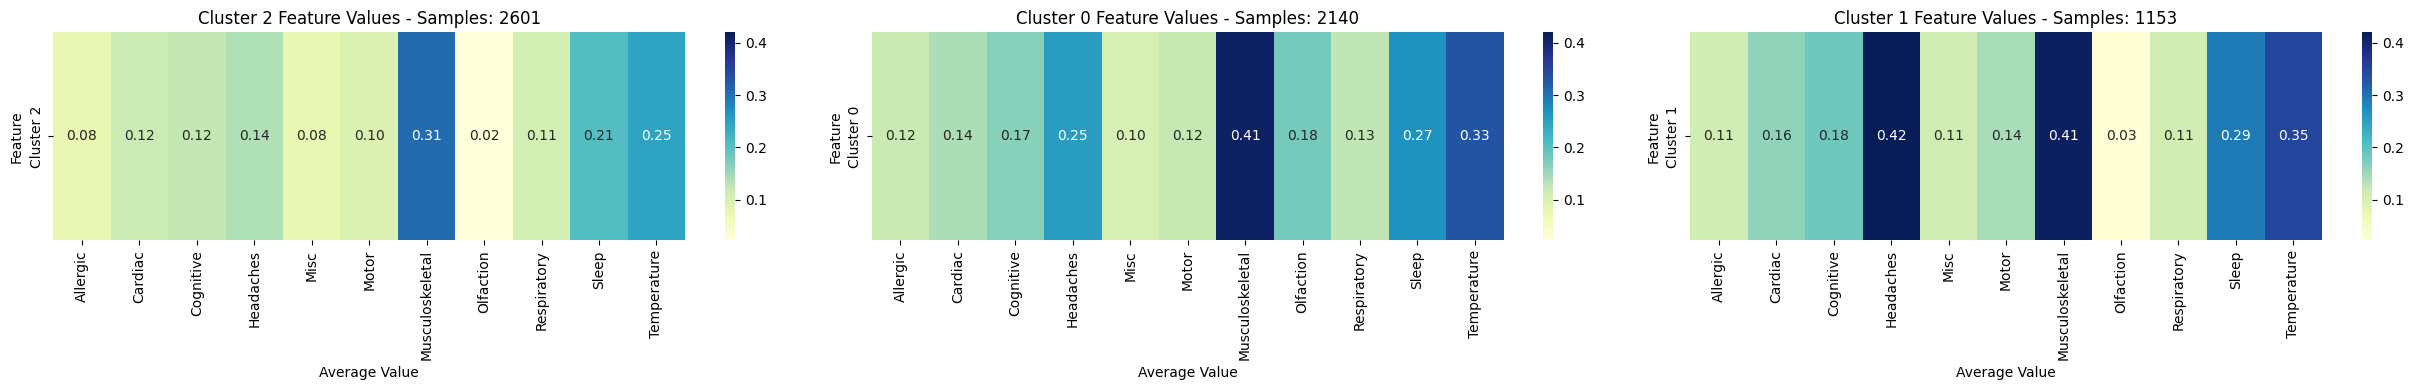

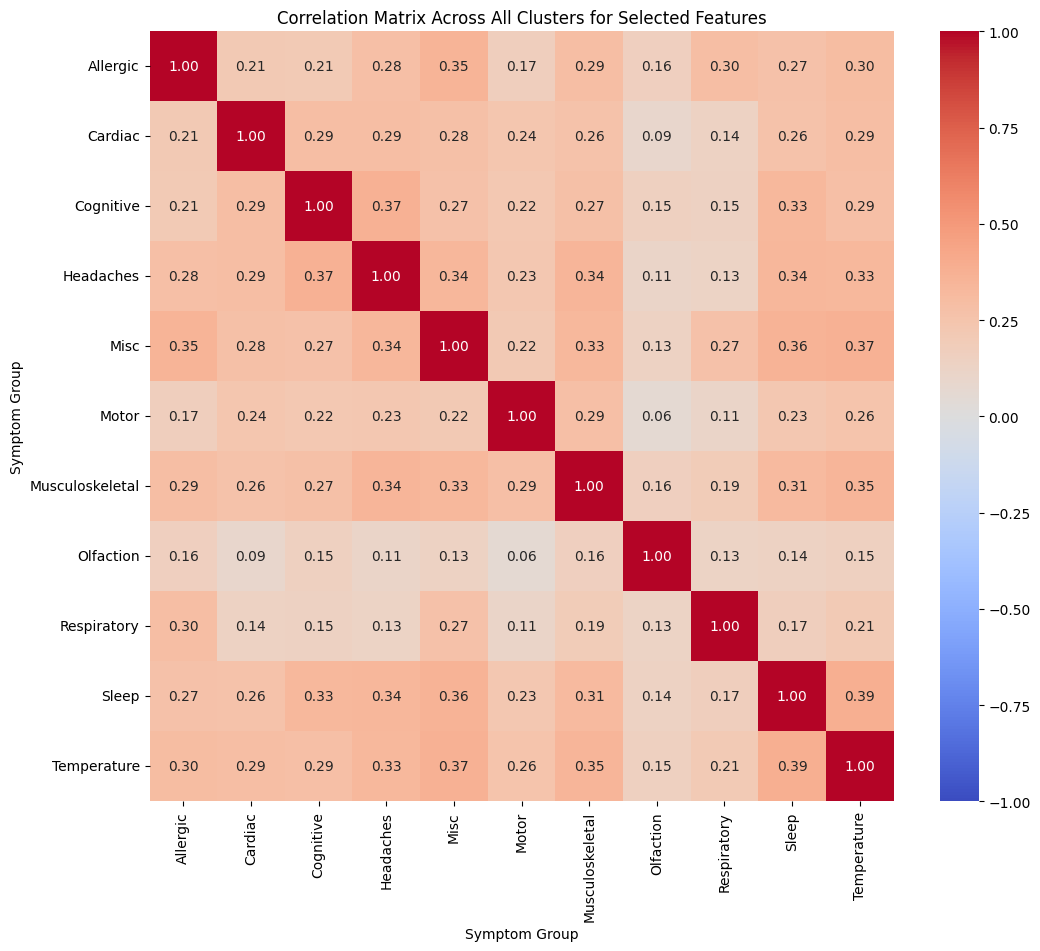

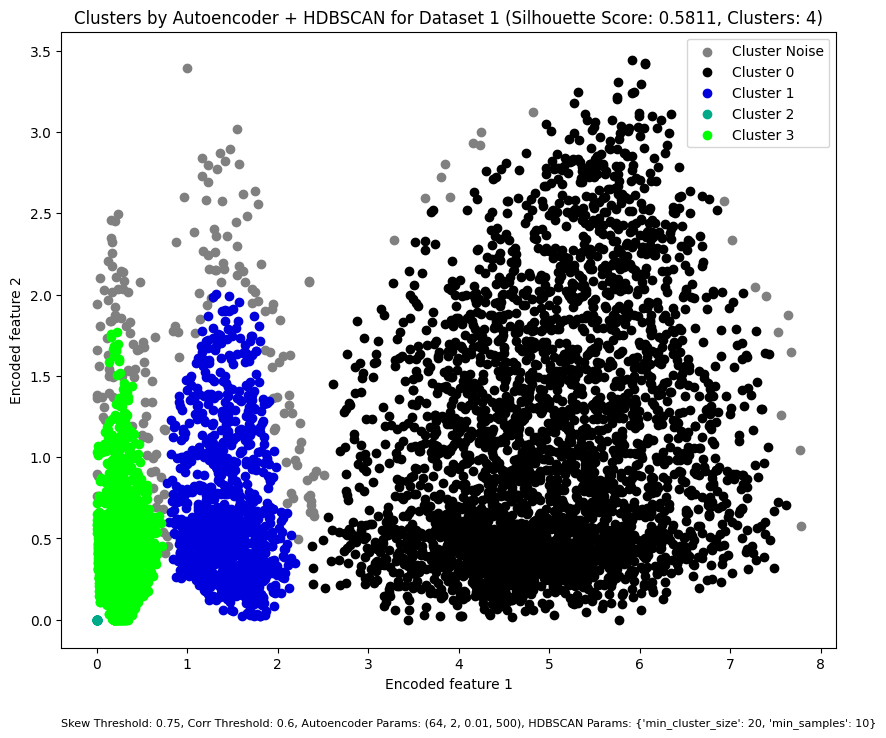

Saved cluster solution to /Users/leo/Programming/PLR/Leo/main/final/grid_autoencoder/cluster_solutions/cluster_solution_1_7.csv


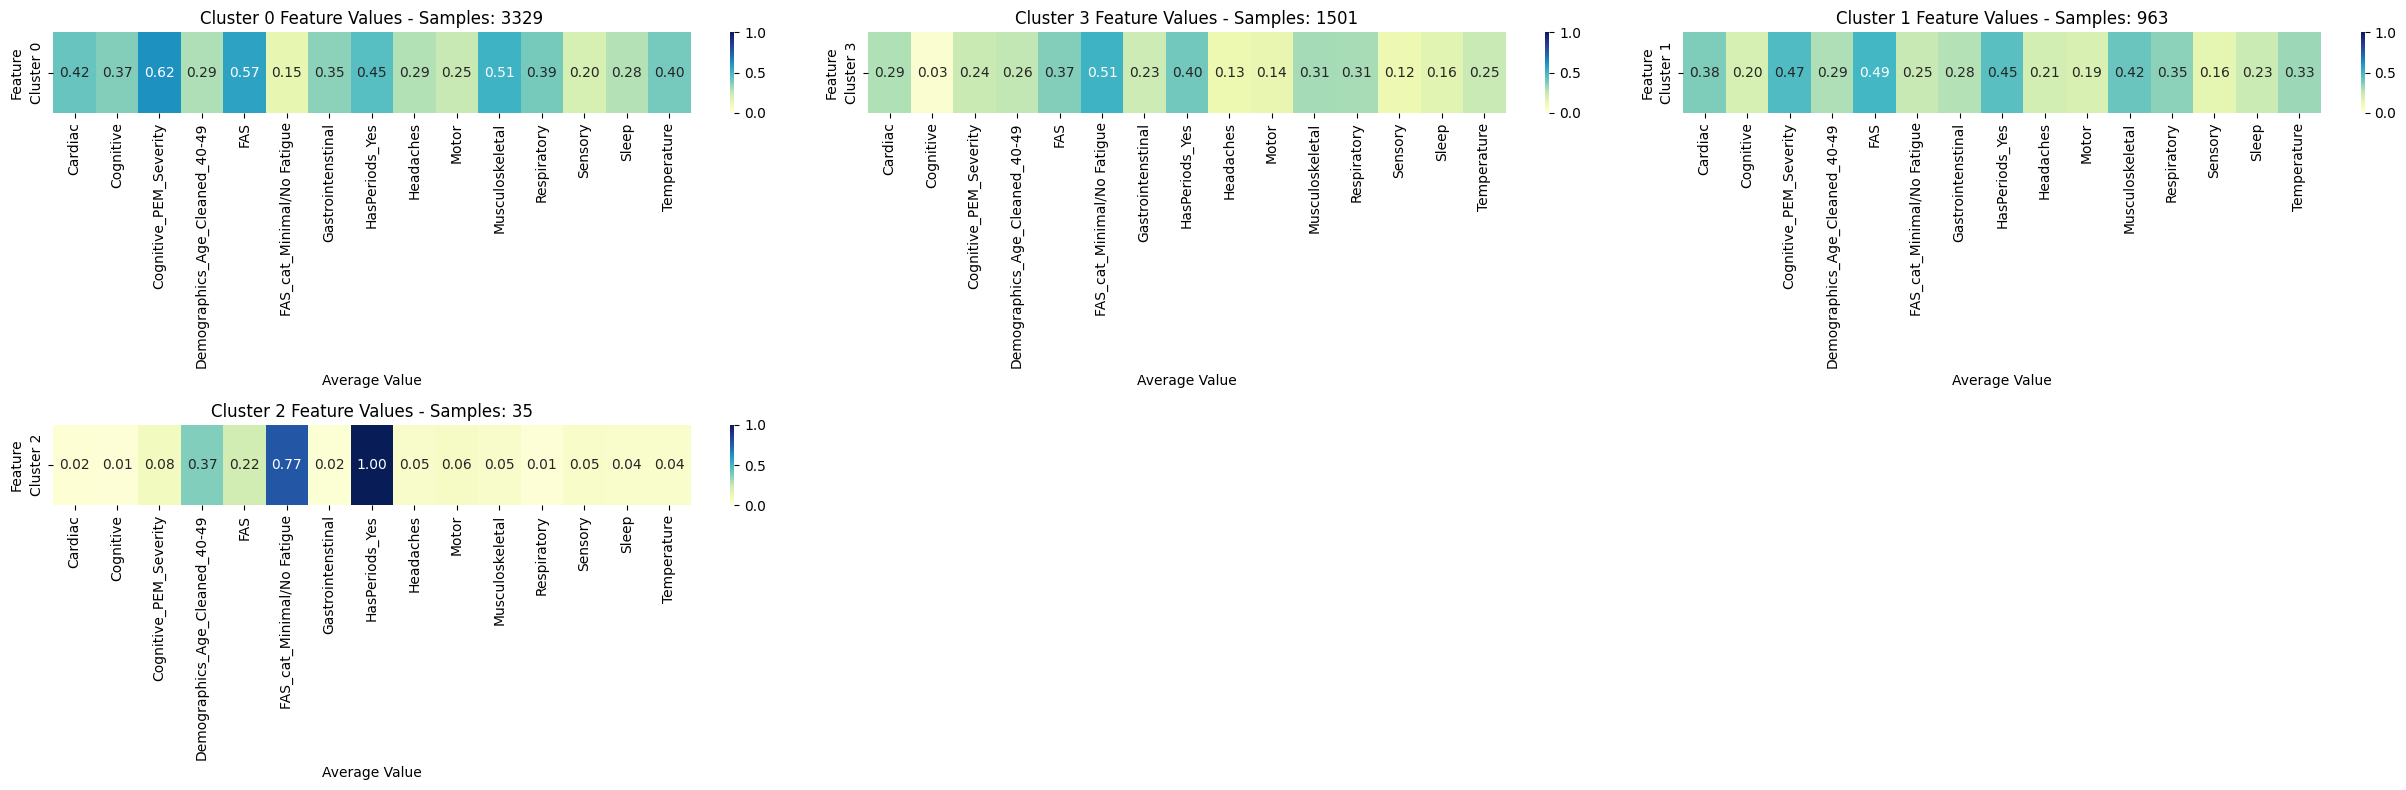

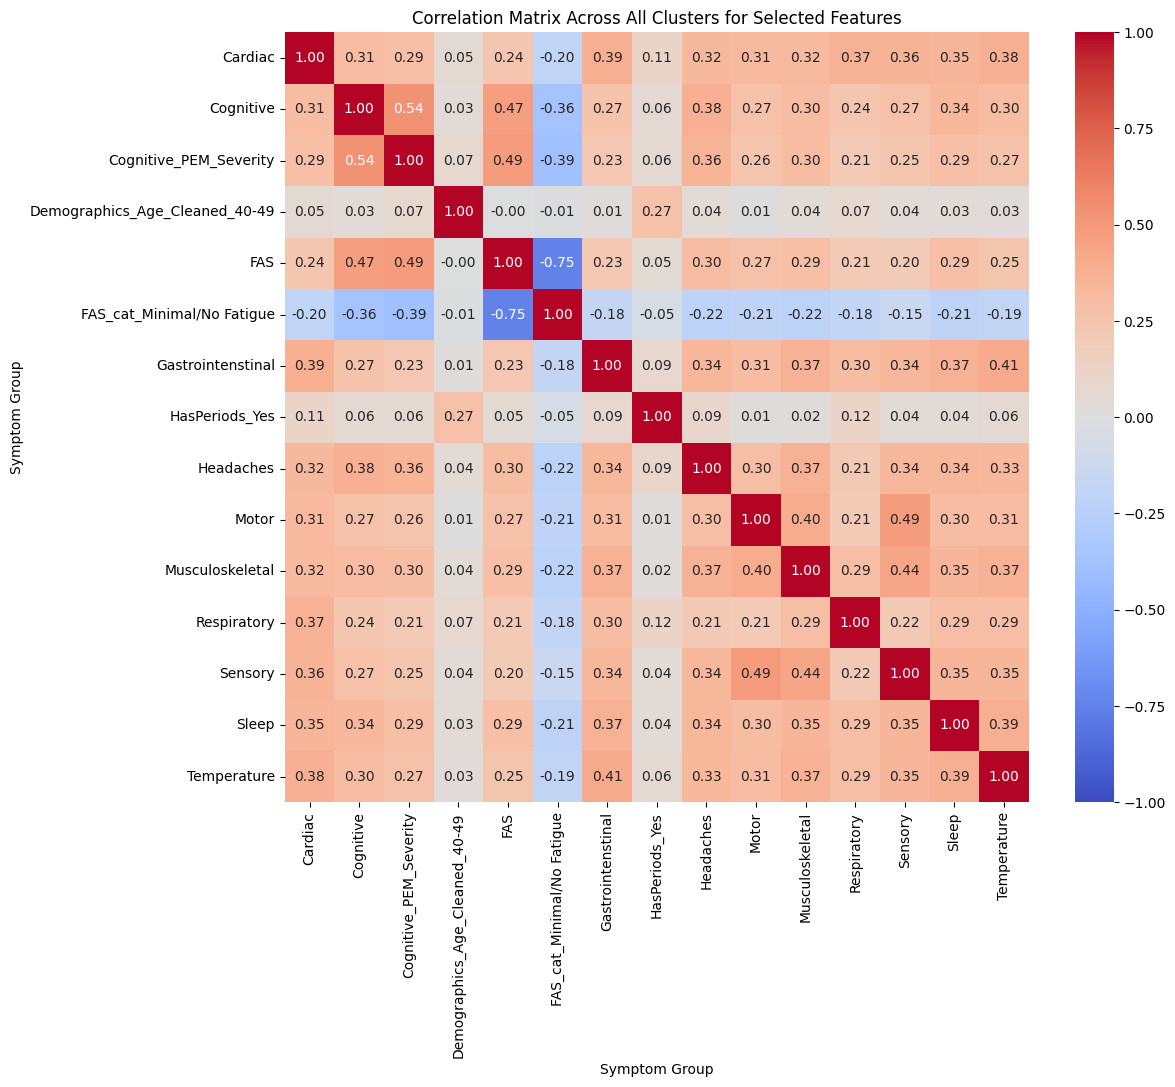

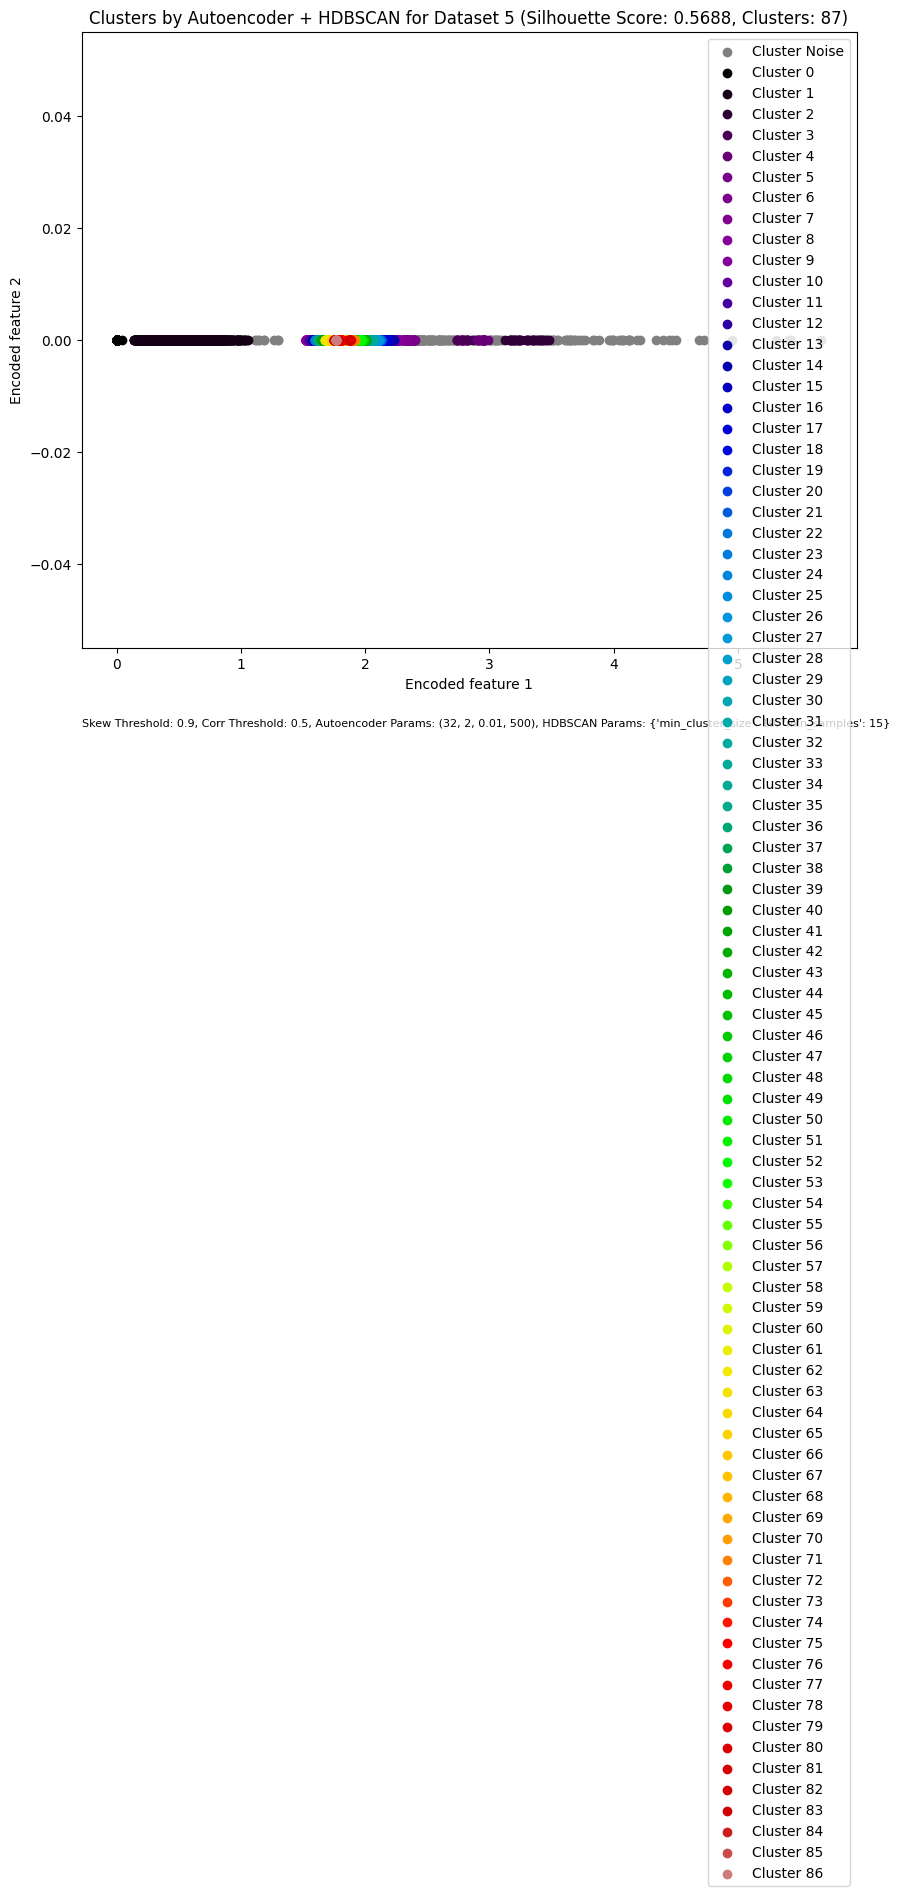

Saved cluster solution to /Users/leo/Programming/PLR/Leo/main/final/grid_autoencoder/cluster_solutions/cluster_solution_5_8.csv


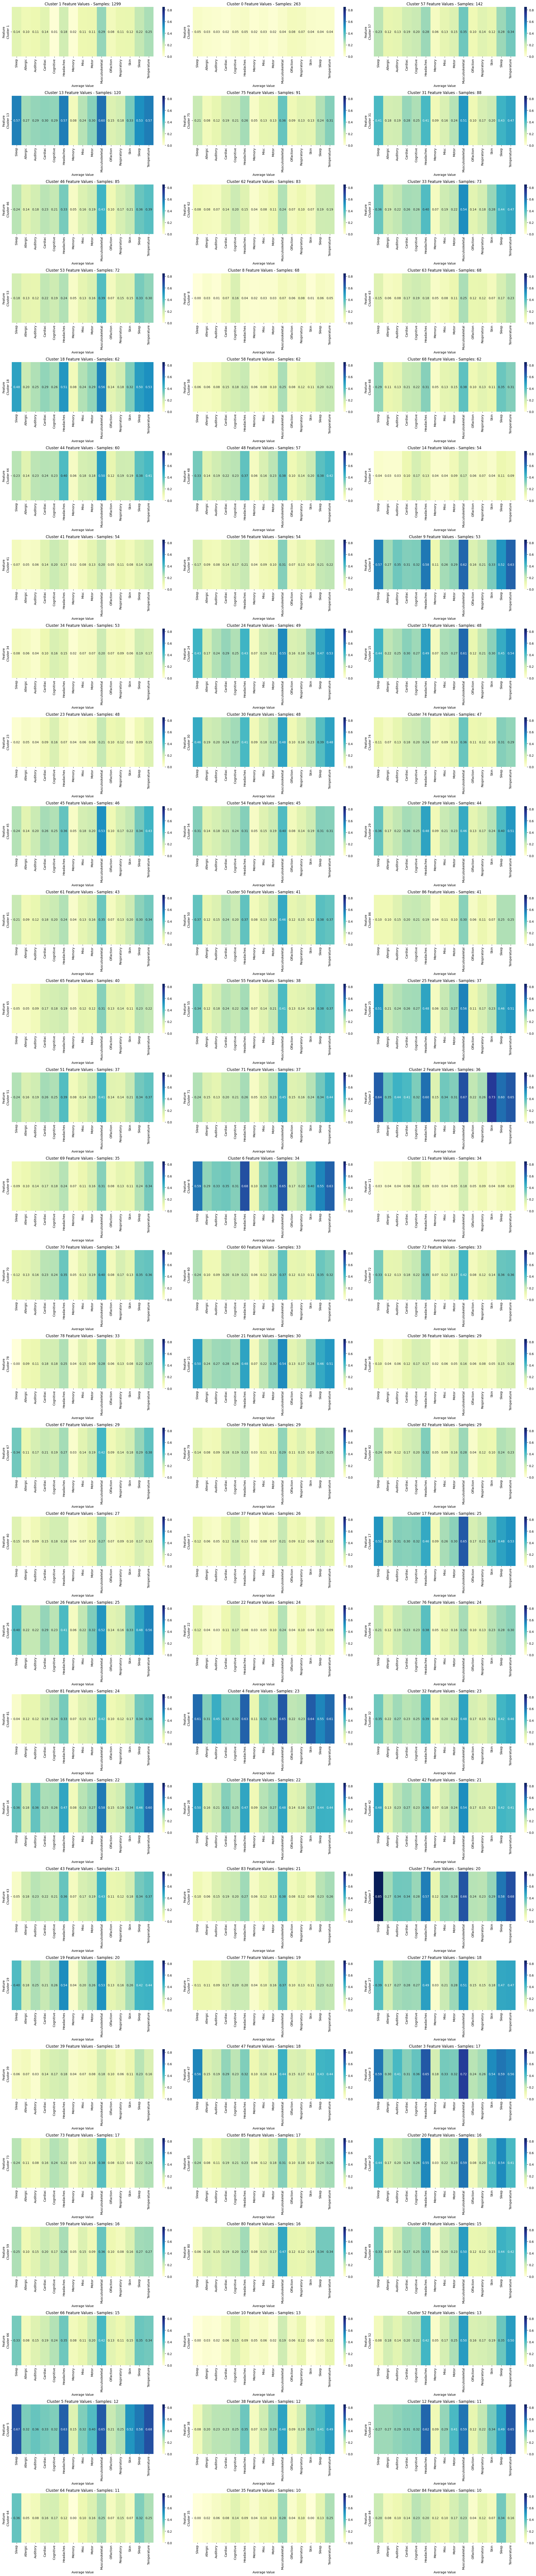

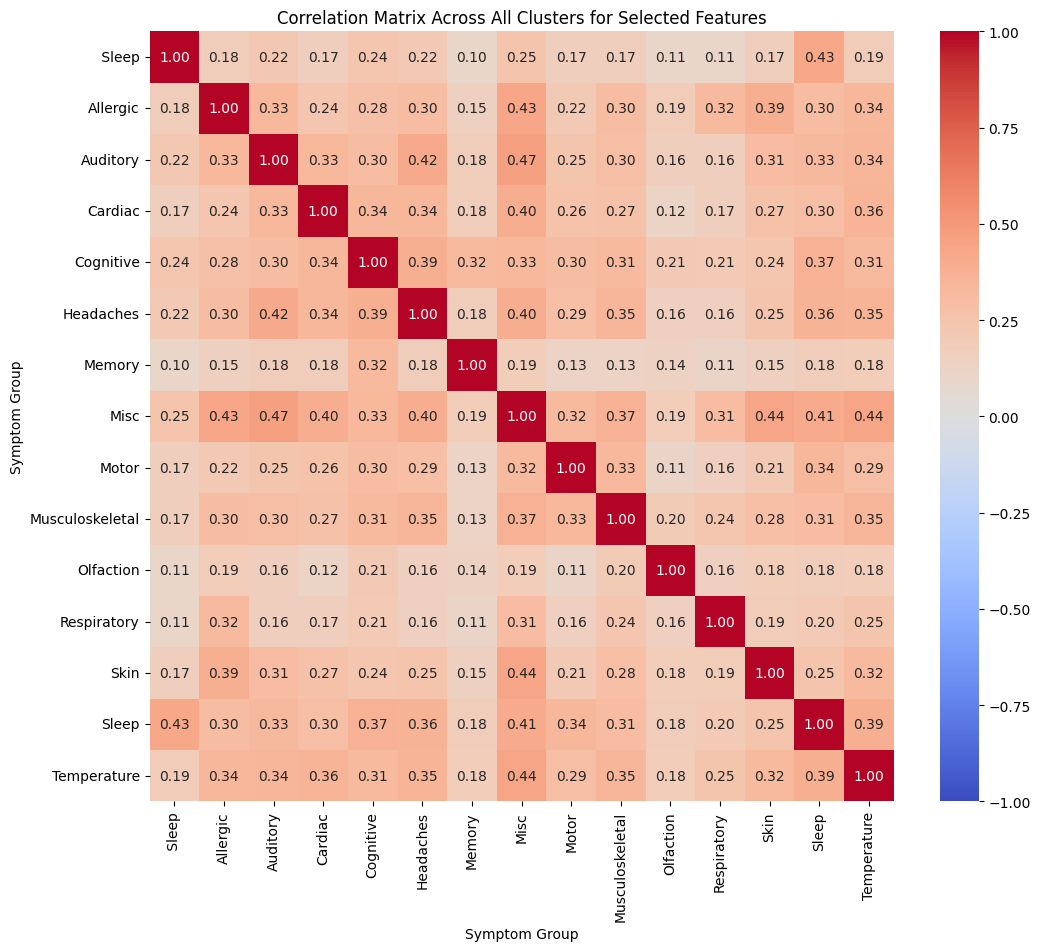

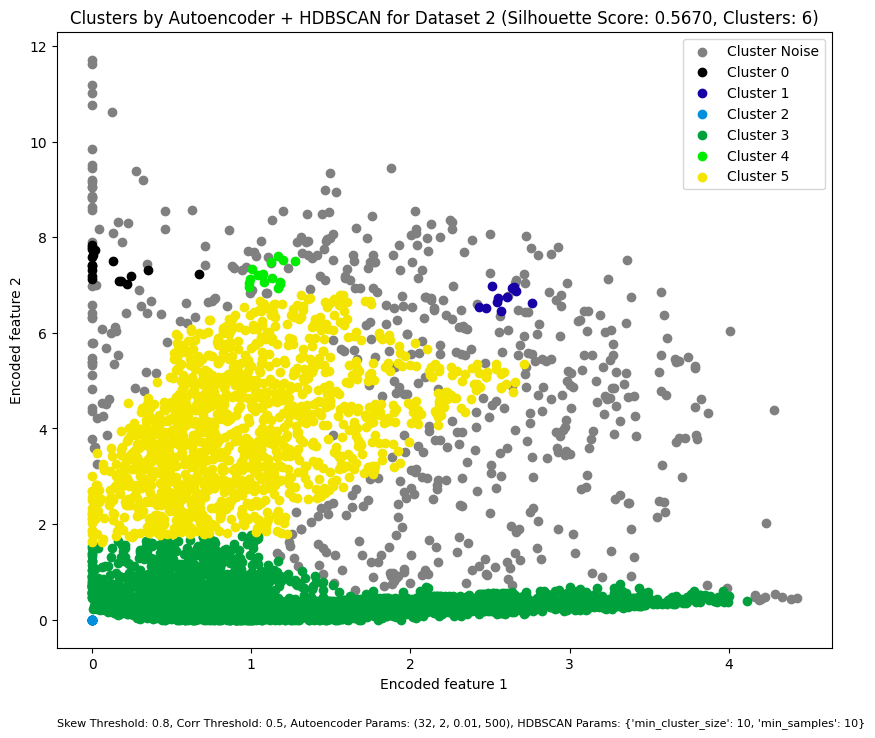

Saved cluster solution to /Users/leo/Programming/PLR/Leo/main/final/grid_autoencoder/cluster_solutions/cluster_solution_2_9.csv


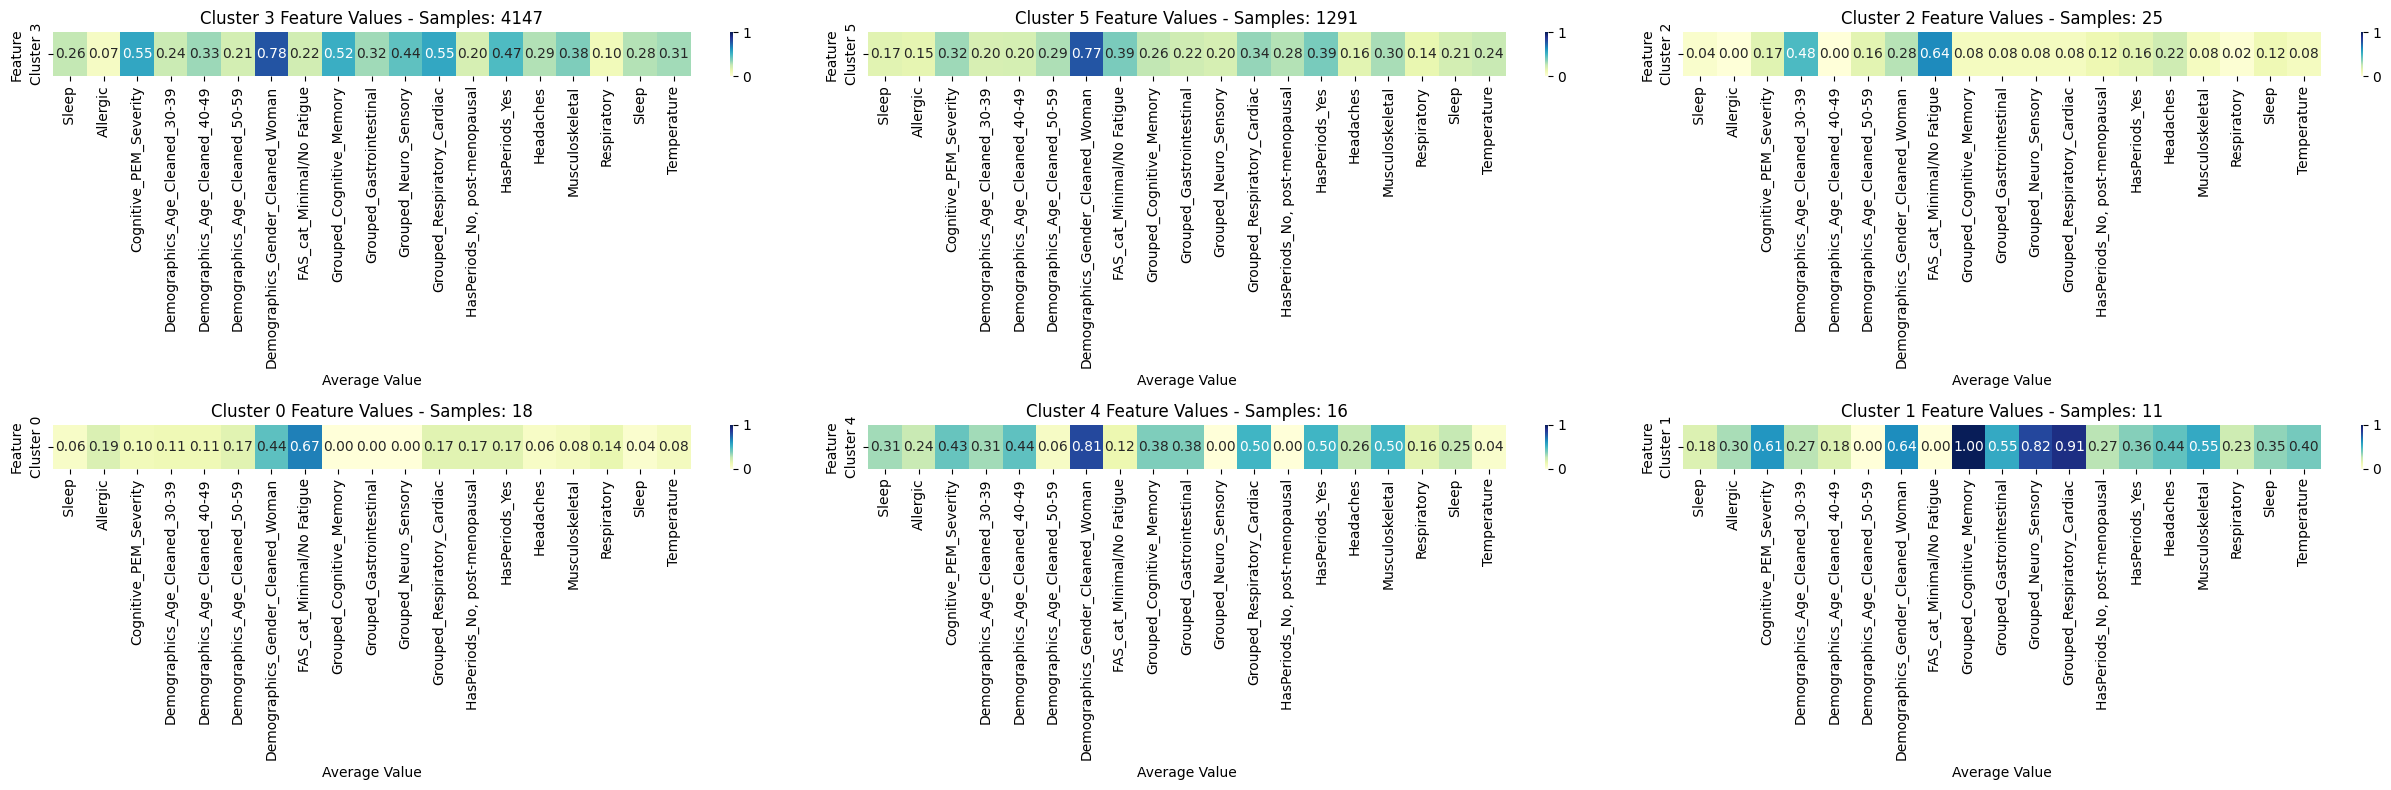

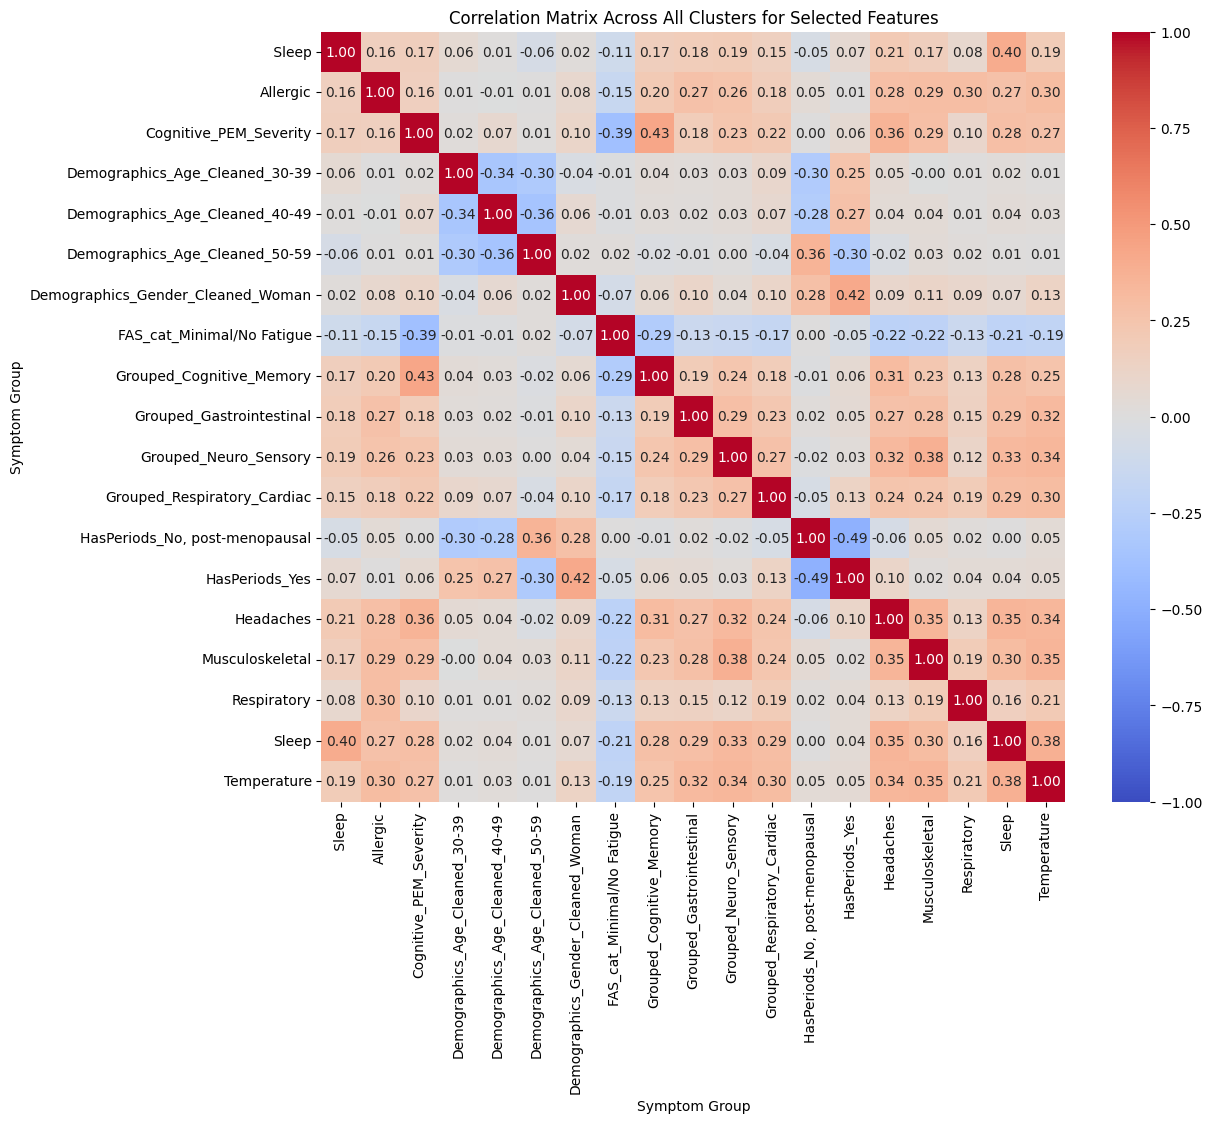

In [5]:
save_dir = '/Users/leo/Programming/PLR/Leo/main/final/grid_autoencoder/cluster_solutions'
os.makedirs(save_dir, exist_ok=True)

# Main processing and visualization loop for Autoencoder
for i, result in enumerate(top_results):
    # Load dataset
    dataset_path = f"/Users/leo/Programming/PLR/Leo/data/dataset_{result['dataset']}.csv"
    data = pd.read_csv(dataset_path).drop(columns=["Unnamed: 0"])

    # Preprocess data
    data_unskewed = drop_skewed_features(data, result['skew_threshold'])
    data_drop_corr = drop_correlated_features(data_unskewed, result['corr_threshold'])

    # Convert data to PyTorch tensors
    tensor_data = torch.tensor(data_drop_corr.values, dtype=torch.float32)

    # Initialize and train Autoencoder
    autoencoder_model = Autoencoder(input_size=tensor_data.shape[1], hidden_size=result['hidden_size'], latent_dim=result['latent_dim'])
    trained_model = train_autoencoder(autoencoder_model, tensor_data, result['learning_rate'], result['epochs'])

    # Apply Autoencoder
    data_encoded = trained_model.encoder(tensor_data).detach().numpy()

    # Apply HDBSCAN with the same parameters as in grid search
    clusterer = hdbscan.HDBSCAN(**result['hdbscan_params'])
    cluster_labels = clusterer.fit_predict(data_encoded)

    # Calculate the actual number of clusters (excluding noise)
    n_clusters_actual = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

    # Visualization
    plt.figure(figsize=(10, 8))
    unique_labels = np.unique(cluster_labels)
    for label in unique_labels:
        color = 'grey' if label == -1 else plt.cm.nipy_spectral(float(label) / len(unique_labels))
        plt.scatter(data_encoded[cluster_labels == label, 0], data_encoded[cluster_labels == label, 1], c=[color], label=f'Cluster {label if label != -1 else "Noise"}')

    # Including Silhouette Score and actual cluster count in the title
    plt.title(f'Clusters by Autoencoder + HDBSCAN for Dataset {result["dataset"]} (Silhouette Score: {result["silhouette_score"]:.4f}, Clusters: {n_clusters_actual})')
    plt.xlabel('Encoded feature 1')
    plt.ylabel('Encoded feature 2')
    plt.legend()

    # Adjusting annotation text to avoid overlap
    params_text = f"Skew Threshold: {result['skew_threshold']}, Corr Threshold: {result['corr_threshold']}, Autoencoder Params: {result['hidden_size'], result['latent_dim'], result['learning_rate'], result['epochs']}, HDBSCAN Params: {result['hdbscan_params']}"
    plt.annotate(params_text, (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)

    plt.show()

    # Save cluster labels
    data_drop_corr['cluster'] = cluster_labels
    # Saving each solution to a CSV file
    save_path = os.path.join(save_dir, f'cluster_solution_{result["dataset"]}_{i}.csv')
    data_drop_corr.to_csv(save_path, index=True, columns=['cluster'])
    print(f"Saved cluster solution to {save_path}")

    # Load and process symptom groupings
    groupings_path = '/Users/leo/Programming/PLR/Leo/data/symptom_groups.csv'
    symptom_groups = pd.read_csv(groupings_path)
    group_dict = dict(zip(symptom_groups['symptom'], symptom_groups['group']))
    dataset_aggregated = aggregate_columns(data_drop_corr, group_dict)

    # plotting cluster averages
    plot_cluster_averages(dataset_aggregated, data_drop_corr['cluster'])

    # Remove 'cluster' column for correlation analysis
    dataset_aggregated_no_cluster = dataset_aggregated.drop(columns=['cluster'], errors='ignore')

    # New code for plotting correlation across all clusters for each solution
    plot_solution_correlations(dataset_aggregated_no_cluster, data_drop_corr['cluster'])

    print("\n" + "=" * 160 + "\n")
